In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

# ------------------
# PATHS / CONSTANTS
# ------------------
ROOT = "/content/drive/MyDrive/Uniocc"

DATASET_ROOT = f"{ROOT}/datasets"
CARLA_PATH   = f"{DATASET_ROOT}/Carla-2Hz-train"
NUSC_PATH    = f"{DATASET_ROOT}/NuScenes-via-Occ3D-2Hz-mini"

CHECKPOINT_DIR = f"{ROOT}/checkpoints"
PLOTS_DIR      = f"{ROOT}/plots"

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

print("Dataset root:", DATASET_ROOT)
print("NuScenes path:", NUSC_PATH)
print("Checkpoints:", CHECKPOINT_DIR)
print("Plots:", PLOTS_DIR)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset root: /content/drive/MyDrive/Uniocc/datasets
NuScenes path: /content/drive/MyDrive/Uniocc/datasets/NuScenes-via-Occ3D-2Hz-mini
Checkpoints: /content/drive/MyDrive/Uniocc/checkpoints
Plots: /content/drive/MyDrive/Uniocc/plots
Using device: cuda


In [3]:
!pip install einops timm matplotlib torch torchvision


# EFFICIENT NET

In [4]:
FREE_LABEL = 10

def binary_occ(x: np.ndarray) -> np.ndarray:
    """
    Convert occ_label volume to binary occupancy:
    1.0 = occupied, 0.0 = free.
    """
    return (x != FREE_LABEL).astype(np.float32)


class UniOccDataset(Dataset):
    """
    UniOcc-style dataset for NuScenes-via-Occ3D-2Hz-mini.
    - Expects .npz files with key 'occ_label' of shape (H, W, T).
    - Produces:
        obs: (obs_len, 1, H, W)
        fut: (fut_len, 1, H, W)
    """

    def __init__(self, root, obs_len=8, fut_len=8):
        self.root = root
        self.obs_len = obs_len
        self.fut_len = fut_len
        self.files = []

        # Collect all .npz files (supports nested folders)
        for folder in sorted(os.listdir(root)):
            fpath = os.path.join(root, folder)
            if os.path.isdir(fpath):
                for f in os.listdir(fpath):
                    if f.endswith(".npz"):
                        self.files.append(os.path.join(fpath, f))
            elif fpath.endswith(".npz"):
                self.files.append(fpath)

        if len(self.files) == 0:
            raise RuntimeError(f"No .npz files found in {root}")

        print(f"Found {len(self.files)} samples in {root}")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        npz = np.load(self.files[idx], allow_pickle=True)
        occ = npz["occ_label"]  # shape: (H, W, T)
        H, W, T = occ.shape

        # Ensure we have enough temporal frames
        assert T >= self.obs_len + self.fut_len, \
            f"File has only {T} frames, requires {self.obs_len + self.fut_len}"

        # Simple fixed slicing: first obs_len frames, then next fut_len
        obs_vol = occ[:, :, :self.obs_len]                           # (H, W, obs_len)
        fut_vol = occ[:, :, self.obs_len:self.obs_len + self.fut_len] # (H, W, fut_len)

        # Binary occupancy
        obs_vol = binary_occ(obs_vol)  # (H, W, obs_len)
        fut_vol = binary_occ(fut_vol)  # (H, W, fut_len)

        # Reorder to (T, 1, H, W) -> channels = time, depth=1
        obs = torch.from_numpy(obs_vol).permute(2, 0, 1).unsqueeze(1)  # (obs_len, 1, H, W)
        fut = torch.from_numpy(fut_vol).permute(2, 0, 1).unsqueeze(1)  # (fut_len, 1, H, W)

        obs = obs.float()
        fut = fut.float()

        return {"obs": obs, "fut": fut}


In [5]:
class MBConv3D(nn.Module):
    """
    Mobile Inverted Bottleneck Conv Block in 3D.
    Stride is (1, s, s) so depth dimension stays 1 throughout.
    """
    def __init__(self, in_ch, out_ch, expansion=4, stride=(1, 1, 1)):
        super().__init__()
        mid = in_ch * expansion
        self.use_res = (stride == (1, 1, 1) and in_ch == out_ch)

        self.block = nn.Sequential(
            # 1x1x1 expansion
            nn.Conv3d(in_ch, mid, kernel_size=1, bias=False),
            nn.BatchNorm3d(mid),
            nn.SiLU(),

            # 3x3x3 depthwise conv, but stride only on spatial dims
            nn.Conv3d(
                mid, mid,
                kernel_size=3,
                stride=stride,
                padding=1,
                groups=mid,
                bias=False
            ),
            nn.BatchNorm3d(mid),
            nn.SiLU(),

            # 1x1x1 projection
            nn.Conv3d(mid, out_ch, kernel_size=1, bias=False),
            nn.BatchNorm3d(out_ch),
        )

    def forward(self, x):
        out = self.block(x)
        if self.use_res:
            return x + out
        return out


class EfficientNet3D_Lite(nn.Module):
    """
    Lightweight 3D EfficientNet-style encoder-decoder:
    Input:  (B, obs_len, 1, H, W)
    Output: (B, fut_len, 1, H, W)
    """

    def __init__(self, in_channels=8, fut_len=8):
        super().__init__()

        # --- STEM ---
        self.stem = nn.Sequential(
            nn.Conv3d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.SiLU(),
        )

        # --- ENCODER (Downsampling only in H/W) ---
        # H,W: 200 -> 100 -> 50 -> 25  (depth remains 1)
        self.blocks = nn.Sequential(
            MBConv3D(32, 32, stride=(1, 1, 1)),
            MBConv3D(32, 64, stride=(1, 2, 2)),   # 200 -> 100
            MBConv3D(64, 64, stride=(1, 1, 1)),
            MBConv3D(64, 96, stride=(1, 2, 2)),   # 100 -> 50
            MBConv3D(96, 96, stride=(1, 1, 1)),
            MBConv3D(96, 128, stride=(1, 2, 2)),  # 50 -> 25
        )

        # --- DECODER (Upsampling only in H/W) ---
        # H,W: 25 -> 50 -> 100 -> 200
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(
                128, 128,
                kernel_size=(1, 2, 2),
                stride=(1, 2, 2)
            ),  # 25 -> 50
            nn.SiLU(),

            nn.ConvTranspose3d(
                128, 64,
                kernel_size=(1, 2, 2),
                stride=(1, 2, 2)
            ),  # 50 -> 100
            nn.SiLU(),

            nn.ConvTranspose3d(
                64, 32,
                kernel_size=(1, 2, 2),
                stride=(1, 2, 2)
            ),  # 100 -> 200
            nn.SiLU(),

            nn.Conv3d(32, fut_len, kernel_size=1)  # (B, fut_len, 1, 200, 200)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        x = self.decoder(x)
        return x


In [6]:
def compute_iou(pred_logits, target, thresh=0.5, eps=1e-6):
    """
    Compute mean IoU over batch for binary occupancy.
    pred_logits: (B, F, 1, H, W)
    target:      (B, F, 1, H, W)
    """
    # Sigmoid + threshold
    pred_prob = torch.sigmoid(pred_logits)
    pred_bin = (pred_prob > thresh).float()

    intersection = (pred_bin * target).sum(dim=(1, 2, 3, 4))
    union        = ((pred_bin + target) > 0).float().sum(dim=(1, 2, 3, 4))

    iou = (intersection + eps) / (union + eps)
    return iou.mean().item()


In [7]:
from torch.cuda.amp import GradScaler

def train_one_epoch(model, loader, optimizer, device):
    model.train()
    loss_fn = nn.BCEWithLogitsLoss()
    scaler = torch.amp.GradScaler("cuda", enabled=(device.type == "cuda"))


    total_loss = 0.0
    total_iou  = 0.0

    for batch in loader:
        obs = batch["obs"].to(device)  # (B, obs_len, 1, H, W)
        fut = batch["fut"].to(device)  # (B, fut_len, 1, H, W)

        optimizer.zero_grad(set_to_none=True)

        if device.type == "cuda":
            with torch.amp.autocast("cuda"):
                pred = model(obs)
                loss = loss_fn(pred, fut)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            pred = model(obs)
            loss = loss_fn(pred, fut)
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        total_iou  += compute_iou(pred.detach(), fut)

    n_batches = len(loader)
    return total_loss / n_batches, total_iou / n_batches


@torch.no_grad()
def eval_one_epoch(model, loader, device):
    model.eval()
    loss_fn = nn.BCEWithLogitsLoss()

    total_loss = 0.0
    total_iou  = 0.0

    for batch in loader:
        obs = batch["obs"].to(device)
        fut = batch["fut"].to(device)

        if device.type == "cuda":
            with torch.amp.autocast("cuda"):
                pred = model(obs)
                loss = loss_fn(pred, fut)
        else:
            pred = model(obs)
            loss = loss_fn(pred, fut)

        total_loss += loss.item()
        total_iou  += compute_iou(pred, fut)

    n_batches = len(loader)
    return total_loss / n_batches, total_iou / n_batches


In [8]:
# -------------
# CONFIG
# -------------
OBS_LEN   = 8
FUT_LEN   = 8
BATCH_SIZE = 2
VAL_SPLIT  = 0.2
LR         = 1e-4
EPOCHS     = 5

# -------------
# DATASET
# -------------
full_dataset = UniOccDataset(NUSC_PATH, obs_len=OBS_LEN, fut_len=FUT_LEN)

val_size   = int(len(full_dataset) * VAL_SPLIT)
train_size = len(full_dataset) - val_size

train_ds, val_ds = random_split(full_dataset, [train_size, val_size])
print(f"Train samples: {len(train_ds)}, Val samples: {len(val_ds)}")

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=(device.type == "cuda"),
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=(device.type == "cuda"),
)

# -------------
# MODEL + OPTIMIZER
# -------------
model = EfficientNet3D_Lite(in_channels=OBS_LEN, fut_len=FUT_LEN).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print("Model params:", sum(p.numel() for p in model.parameters()) / 1e6, "M")


Found 404 samples in /content/drive/MyDrive/Uniocc/datasets/NuScenes-via-Occ3D-2Hz-mini
Train samples: 324, Val samples: 80
Model params: 0.41652 M


In [12]:
# ===========================================
# TRAINING LOOP (Torch 2.x AMP Compatible)
# ===========================================
from tqdm import tqdm
import os
import torch
import torch.nn as nn

print("\nStarting training...\n")

# ----- Metrics -----
train_losses, val_losses = [], []
train_ious,  val_ious  = [], []

# ----- Checkpoints -----
best_val_iou = -1.0
best_ckpt_path = os.path.join(CHECKPOINT_DIR, "efficientnet3d_lite_best.pth")
last_ckpt_path = os.path.join(CHECKPOINT_DIR, "efficientnet3d_lite_last.pth")

# ----- Loss Function -----
criterion = nn.BCEWithLogitsLoss()

# ----- AMP Setup -----
use_amp = (device.type == "cuda")
scaler  = torch.amp.GradScaler("cuda") if use_amp else None
autocast = lambda: torch.amp.autocast("cuda") if use_amp else torch.no_grad()

# ===========================================
# TRAINING LOOP
# ===========================================
for epoch in range(1, EPOCHS + 1):

    # -------------------------
    # TRAIN
    # -------------------------
    model.train()
    total_loss, total_iou = 0.0, 0.0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch} ⟩ Training", leave=False)

    for batch in train_bar:
        obs = batch["obs"].to(device)
        fut = batch["fut"].to(device)

        optimizer.zero_grad(set_to_none=True)

        # ---- Forward + Backward ----
        if use_amp:
            with torch.amp.autocast("cuda"):
                pred = model(obs)
                loss = criterion(pred, fut)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        else:
            pred = model(obs)
            loss = criterion(pred, fut)
            loss.backward()
            optimizer.step()

        # ---- Metrics ----
        batch_iou = compute_iou(pred.detach(), fut)
        total_loss += loss.item()
        total_iou  += batch_iou

        train_bar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "IoU":  f"{batch_iou:.4f}"
        })

    train_loss = total_loss / len(train_loader)
    train_iou  = total_iou  / len(train_loader)

    # -------------------------
    # VALIDATION
    # -------------------------
    model.eval()
    total_loss, total_iou = 0.0, 0.0

    val_bar = tqdm(val_loader, desc=f"Epoch {epoch} ⟩ Validating", leave=False)

    with torch.no_grad():
        for batch in val_bar:
            obs = batch["obs"].to(device)
            fut = batch["fut"].to(device)

            if use_amp:
                with torch.amp.autocast("cuda"):
                    pred = model(obs)
                    loss = criterion(pred, fut)
            else:
                pred = model(obs)
                loss = criterion(pred, fut)

            batch_iou = compute_iou(pred, fut)
            total_loss += loss.item()
            total_iou  += batch_iou

            val_bar.set_postfix({
                "loss": f"{loss.item():.4f}",
                "IoU":  f"{batch_iou:.4f}"
            })

    val_loss = total_loss / len(val_loader)
    val_iou  = total_iou  / len(val_loader)


    # -------------------------
    # LOGGING
    # -------------------------
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_ious.append(train_iou)
    val_ious.append(val_iou)

    print(
        f"[Epoch {epoch:02d}] "
        f"train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
        f"train_IoU={train_iou:.4f}, val_IoU={val_iou:.4f}"
    )

    # -------------------------
    # SAVE BEST CHECKPOINT
    # -------------------------
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(model.state_dict(), best_ckpt_path)
        print(f"  ➜ New BEST model saved to {best_ckpt_path} (IoU={val_iou:.4f})")


# -------------------------
# SAVE LAST CHECKPOINT
# -------------------------
torch.save(model.state_dict(), last_ckpt_path)
print(f"\n✓ Last model saved to {last_ckpt_path}")
print("✓ Training complete!")



Starting training...



[Epoch 01] train_loss=0.1993, val_loss=0.1377, train_IoU=0.0208, val_IoU=0.0186
  ➜ New BEST model saved to /content/drive/MyDrive/Uniocc/checkpoints/efficientnet3d_lite_best.pth (IoU=0.0186)


[Epoch 02] train_loss=0.1403, val_loss=0.1178, train_IoU=0.0065, val_IoU=0.0002


[Epoch 03] train_loss=0.1251, val_loss=0.1120, train_IoU=0.0003, val_IoU=0.0000


[Epoch 04] train_loss=0.1207, val_loss=0.1090, train_IoU=0.0002, val_IoU=0.0003


[Epoch 05] train_loss=0.1174, val_loss=0.1064, train_IoU=0.0013, val_IoU=0.0032

✓ Last model saved to /content/drive/MyDrive/Uniocc/checkpoints/efficientnet3d_lite_last.pth
✓ Training complete!


In [13]:
# ===========================================
# TRAINING LOOP: Weighted BCE + Dice Loss
# ===========================================
import torch
import torch.nn as nn
from tqdm import tqdm

# ---- Loss configuration (industry-style) ----
POS_WEIGHT  = 20.0   # emphasize occupied voxels; tune if needed
BCE_WEIGHT  = 0.7
DICE_WEIGHT = 0.3

pos_weight_tensor = torch.tensor([POS_WEIGHT], device=device)
bce_loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

def dice_loss(logits, target, eps=1e-6):
    """
    Soft Dice loss for binary maps.
    logits: (B, F, 1, H, W)
    target: (B, F, 1, H, W)
    """
    probs = torch.sigmoid(logits)
    # flatten
    probs_flat  = probs.view(probs.size(0), -1)
    target_flat = target.view(target.size(0), -1)

    intersection = (probs_flat * target_flat).sum(dim=1)
    union        = probs_flat.sum(dim=1) + target_flat.sum(dim=1)

    dice = (2 * intersection + eps) / (union + eps)
    return 1.0 - dice.mean()


# ---- Training state ----
train_losses, val_losses = [], []
train_ious,  val_ious  = [], []

best_val_iou = -1.0
best_ckpt_path = os.path.join(CHECKPOINT_DIR, "efficientnet3d_lite_best.pth")
last_ckpt_path = os.path.join(CHECKPOINT_DIR, "efficientnet3d_lite_last.pth")

print("Starting training with Weighted BCE + Dice...\n")

for epoch in range(1, EPOCHS + 1):

    # =====================================
    # TRAIN
    # =====================================
    model.train()
    scaler = torch.amp.GradScaler("cuda", enabled=(device.type == "cuda"))

    total_loss = 0.0
    total_iou  = 0.0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch} ⟩ Training", leave=False)

    for batch in train_bar:
        obs = batch["obs"].to(device)  # (B, OBS_LEN, 1, H, W)
        fut = batch["fut"].to(device)  # (B, FUT_LEN, 1, H, W)

        optimizer.zero_grad(set_to_none=True)

        if device.type == "cuda":
            with torch.amp.autocast("cuda"):
                logits = model(obs)
                bce    = bce_loss_fn(logits, fut)
                d_loss = dice_loss(logits, fut)
                loss   = BCE_WEIGHT * bce + DICE_WEIGHT * d_loss
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(obs)
            bce    = bce_loss_fn(logits, fut)
            d_loss = dice_loss(logits, fut)
            loss   = BCE_WEIGHT * bce + DICE_WEIGHT * d_loss

            loss.backward()
            optimizer.step()

        batch_iou = compute_iou(logits.detach(), fut)

        total_loss += loss.item()
        total_iou  += batch_iou

        train_bar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "IoU":  f"{batch_iou:.4f}"
        })

    train_loss = total_loss / len(train_loader)
    train_iou  = total_iou  / len(train_loader)


    # =====================================
    # VALIDATION
    # =====================================
    model.eval()
    total_loss = 0.0
    total_iou  = 0.0

    val_bar = tqdm(val_loader, desc=f"Epoch {epoch} ⟩ Validating", leave=False)

    with torch.no_grad():
        for batch in val_bar:
            obs = batch["obs"].to(device)
            fut = batch["fut"].to(device)

            if device.type == "cuda":
                with torch.amp.autocast("cuda"):
                    logits = model(obs)
                    bce    = bce_loss_fn(logits, fut)
                    d_loss = dice_loss(logits, fut)
                    loss   = BCE_WEIGHT * bce + DICE_WEIGHT * d_loss
            else:
                logits = model(obs)
                bce    = bce_loss_fn(logits, fut)
                d_loss = dice_loss(logits, fut)
                loss   = BCE_WEIGHT * bce + DICE_WEIGHT * d_loss

            batch_iou = compute_iou(logits, fut)

            total_loss += loss.item()
            total_iou  += batch_iou

            val_bar.set_postfix({
                "loss": f"{loss.item():.4f}",
                "IoU":  f"{batch_iou:.4f}"
            })

    val_loss = total_loss / len(val_loader)
    val_iou  = total_iou  / len(val_loader)


    # =====================================
    # LOGGING + CHECKPOINTS
    # =====================================
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_ious.append(train_iou)
    val_ious.append(val_iou)

    print(
        f"[Epoch {epoch:02d}] "
        f"train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
        f"train_IoU={train_iou:.4f}, val_IoU={val_iou:.4f}"
    )

    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(model.state_dict(), best_ckpt_path)
        print(f"  ➜ New BEST model saved to {best_ckpt_path} (IoU={val_iou:.4f})")


# save last model
torch.save(model.state_dict(), last_ckpt_path)
print(f"\n✓ Last model saved to {last_ckpt_path}")
print("✓ Training complete with Weighted BCE + Dice.")


Starting training with Weighted BCE + Dice...



[Epoch 01] train_loss=0.7986, val_loss=0.7072, train_IoU=0.1178, val_IoU=0.1201
  ➜ New BEST model saved to /content/drive/MyDrive/Uniocc/checkpoints/efficientnet3d_lite_best.pth (IoU=0.1201)


[Epoch 02] train_loss=0.7327, val_loss=0.7030, train_IoU=0.1341, val_IoU=0.1274
  ➜ New BEST model saved to /content/drive/MyDrive/Uniocc/checkpoints/efficientnet3d_lite_best.pth (IoU=0.1274)


[Epoch 03] train_loss=0.7122, val_loss=0.6896, train_IoU=0.1393, val_IoU=0.1329
  ➜ New BEST model saved to /content/drive/MyDrive/Uniocc/checkpoints/efficientnet3d_lite_best.pth (IoU=0.1329)


[Epoch 04] train_loss=0.6969, val_loss=0.6818, train_IoU=0.1442, val_IoU=0.1331
  ➜ New BEST model saved to /content/drive/MyDrive/Uniocc/checkpoints/efficientnet3d_lite_best.pth (IoU=0.1331)


[Epoch 05] train_loss=0.6817, val_loss=0.6837, train_IoU=0.1491, val_IoU=0.1339
  ➜ New BEST model saved to /content/drive/MyDrive/Uniocc/checkpoints/efficientnet3d_lite_best.pth (IoU=0.1339)

✓ Last model saved to /content/drive/MyDrive/Uniocc/checkpoints/efficientnet3d_lite_last.pth
✓ Training complete with Weighted BCE + Dice.


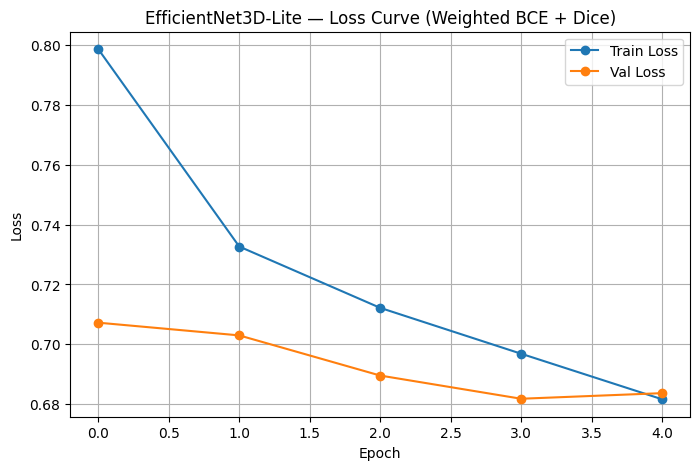

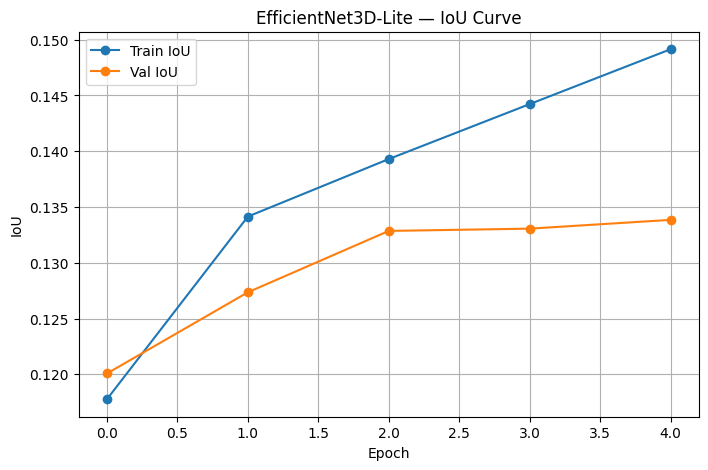

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss", marker="o")
plt.plot(val_losses, label="Val Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("EfficientNet3D-Lite — Loss Curve (Weighted BCE + Dice)")
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(8,5))
plt.plot(train_ious, label="Train IoU", marker="o")
plt.plot(val_ious, label="Val IoU", marker="o")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.title("EfficientNet3D-Lite — IoU Curve")
plt.grid(True)
plt.legend()
plt.show()


# MOBILENET

In [23]:
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

ROOT = "/content/drive/MyDrive/Uniocc"

DATASET_ROOT = f"{ROOT}/datasets"
NUSC_PATH    = f"{DATASET_ROOT}/NuScenes-via-Occ3D-2Hz-mini"

CHECKPOINT_DIR = f"{ROOT}/checkpoints"
PLOTS_DIR      = f"{ROOT}/plots"

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using: cuda


In [24]:
FREE_LABEL = 10

def binary_occ(x):
    return (x != FREE_LABEL).astype(np.float32)

class UniOccDataset(Dataset):
    def __init__(self, root, obs_len=8, fut_len=8):
        self.obs_len = obs_len
        self.fut_len = fut_len
        self.files = []

        for folder in sorted(os.listdir(root)):
            p = os.path.join(root, folder)
            if os.path.isdir(p):
                for f in os.listdir(p):
                    if f.endswith(".npz"):
                        self.files.append(os.path.join(p, f))
            elif p.endswith(".npz"):
                self.files.append(p)

        print(f"Found {len(self.files)} samples in {root}")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        npz = np.load(self.files[idx], allow_pickle=True)
        occ = npz["occ_label"]  # (H,W,T)

        H, W, T = occ.shape
        assert T >= self.obs_len + self.fut_len

        obs = occ[:, :, :self.obs_len]
        fut = occ[:, :, self.obs_len:self.obs_len+self.fut_len]

        obs = binary_occ(obs)
        fut = binary_occ(fut)

        # (T,1,H,W)
        obs = torch.tensor(obs).permute(2,0,1).unsqueeze(1).float()
        fut = torch.tensor(fut).permute(2,0,1).unsqueeze(1).float()

        return {"obs": obs, "fut": fut}


In [29]:
import torch.nn.functional as F

class DepthwiseSeparableConv3D(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        self.depthwise = nn.Conv3d(
            in_ch, in_ch, kernel_size=3, stride=stride,
            padding=1, groups=in_ch, bias=False
        )
        self.dw_bn = nn.BatchNorm3d(in_ch)

        self.pointwise = nn.Conv3d(
            in_ch, out_ch, kernel_size=1, bias=False
        )
        self.pw_bn = nn.BatchNorm3d(out_ch)

    def forward(self, x):
        x = F.relu(self.dw_bn(self.depthwise(x)))
        x = F.relu(self.pw_bn(self.pointwise(x)))
        return x


class MobileNet3D_Lite(nn.Module):
    def __init__(self, in_channels=8, fut_len=8):
        super().__init__()
        self.fut_len = fut_len

        self.enc1 = DepthwiseSeparableConv3D(in_channels, 32)
        self.enc2 = DepthwiseSeparableConv3D(32, 64, stride=2)
        self.enc3 = DepthwiseSeparableConv3D(64, 128, stride=2)

        self.bottleneck = DepthwiseSeparableConv3D(128, 128)

        self.dec1 = DepthwiseSeparableConv3D(128, 64)
        self.dec2 = DepthwiseSeparableConv3D(64, 32)
        self.dec3 = nn.Conv3d(32, fut_len, kernel_size=1)

    def forward(self, x):
      # x: (B, 8, 1, H, W)

      # ✅ Move temporal dimension into the channel dimension
      # (B, 8, 1, H, W) → (B, 8, H, W)
      x = x.squeeze(2)

      # ✅ Add depth dimension back
      # (B, 8, H, W) → (B, 8, 1, H, W)
      x = x.unsqueeze(2)

      # ✅ Encoder
      x1 = self.enc1(x)
      x2 = self.enc2(x1)
      x3 = self.enc3(x2)

      # ✅ Bottleneck
      x = self.bottleneck(x3)

      # ✅ Decoder
      x = F.interpolate(x, scale_factor=(1, 2, 2), mode='trilinear', align_corners=False)
      x = self.dec1(x)

      x = F.interpolate(x, scale_factor=(1, 2, 2), mode='trilinear', align_corners=False)
      x = self.dec2(x)

      # ✅ Final logits
      x = self.dec3(x)  # (B, fut_len, 1, H, W)

      return x



In [30]:
criterion = nn.BCEWithLogitsLoss()

def compute_iou(pred, target, thresh=0.5):
    pred_bin = (pred > thresh).float()
    inter = (pred_bin * target).sum()
    union = (pred_bin + target - pred_bin*target).sum()
    return (inter / (union + 1e-6)).item()

def train_epoch(model, loader, optimizer):
    model.train()
    total_loss, total_iou = 0.0, 0.0

    scaler = torch.amp.GradScaler("cuda")

    for batch in tqdm(loader, desc="Training", leave=False):
        obs = batch["obs"].to(device)
        fut = batch["fut"].to(device)

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast("cuda"):
            pred = model(obs)
            loss = criterion(pred, fut)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        total_iou  += compute_iou(pred.detach(), fut)

    return total_loss / len(loader), total_iou / len(loader)

def val_epoch(model, loader):
    model.eval()
    total_loss, total_iou = 0.0, 0.0

    with torch.no_grad():
        for batch in tqdm(loader, desc="Validating", leave=False):
            obs = batch["obs"].to(device)
            fut = batch["fut"].to(device)

            with torch.amp.autocast("cuda"):
                pred = model(obs)
                loss = criterion(pred, fut)

            total_loss += loss.item()
            total_iou  += compute_iou(pred, fut)

    return total_loss / len(loader), total_iou / len(loader)


In [31]:
batch = next(iter(train_loader))
print(batch["obs"].shape)


torch.Size([2, 8, 1, 200, 200])


In [32]:
OBS_LEN = 8
FUT_LEN = 8
BATCH = 2
EPOCHS = 5

dataset = UniOccDataset(NUSC_PATH, obs_len=OBS_LEN, fut_len=FUT_LEN)

train_len = int(0.8 * len(dataset))
val_len   = len(dataset) - train_len

train_ds, val_ds = random_split(dataset, [train_len, val_len])

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=BATCH, shuffle=False, num_workers=2)

model = MobileNet3D_Lite(in_channels=OBS_LEN, fut_len=FUT_LEN).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)

train_losses, val_losses = [], []
train_ious, val_ious = [], []

best_iou = -1
best_path = os.path.join(CHECKPOINT_DIR, "mobilenet3d_best.pth")

for epoch in range(1, EPOCHS+1):
    tl, ti = train_epoch(model, train_loader, opt)
    vl, vi = val_epoch(model, val_loader)

    train_losses.append(tl)
    val_losses.append(vl)
    train_ious.append(ti)
    val_ious.append(vi)

    print(f"[Epoch {epoch}] TL={tl:.4f}, VL={vl:.4f}, TI={ti:.4f}, VI={vi:.4f}")

    if vi > best_iou:
        best_iou = vi
        torch.save(model.state_dict(), best_path)
        print(f"  ✔ Saved BEST model (IoU={vi:.4f})")

torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, "mobilenet3d_last.pth"))


Found 404 samples in /content/drive/MyDrive/Uniocc/datasets/NuScenes-via-Occ3D-2Hz-mini


[Epoch 1] TL=0.6520, VL=0.5888, TI=0.0405, VI=0.0411
  ✔ Saved BEST model (IoU=0.0411)


[Epoch 2] TL=0.5329, VL=0.4826, TI=0.0212, VI=0.0142


[Epoch 3] TL=0.4403, VL=0.4039, TI=0.0064, VI=0.0054


[Epoch 4] TL=0.3674, VL=0.3380, TI=0.0018, VI=0.0006


[Epoch 5] TL=0.3087, VL=0.2852, TI=0.0000, VI=0.0000


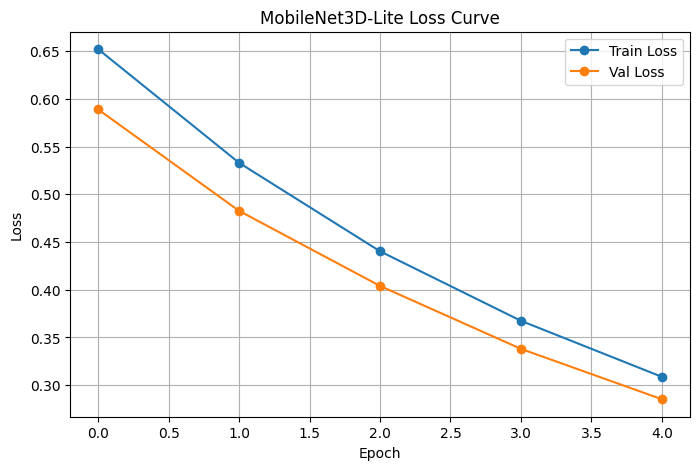

In [33]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss", marker="o")
plt.plot(val_losses, label="Val Loss", marker="o")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("MobileNet3D-Lite Loss Curve")
plt.legend(); plt.grid(True); plt.show()


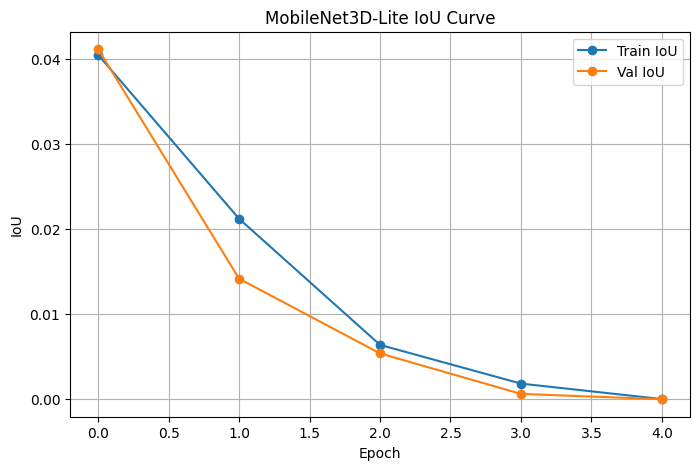

In [34]:
plt.figure(figsize=(8,5))
plt.plot(train_ious, label="Train IoU", marker="o")
plt.plot(val_ious, label="Val IoU", marker="o")
plt.xlabel("Epoch"); plt.ylabel("IoU")
plt.title("MobileNet3D-Lite IoU Curve")
plt.legend(); plt.grid(True); plt.show()


In [35]:
@torch.no_grad()
def visualize_sample(model, loader, index=0):
    batch = next(iter(loader))
    obs = batch["obs"][index:index+1].to(device)
    fut = batch["fut"][index:index+1]

    pred = torch.sigmoid(model(obs)).cpu()

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("GT Future Occupancy (1 Slice)")
    plt.imshow(fut[0,0,0], cmap="gray")

    plt.subplot(1,2,2)
    plt.title("Predicted Occupancy (1 Slice)")
    plt.imshow(pred[0,0,0], cmap="gray")
    plt.show()


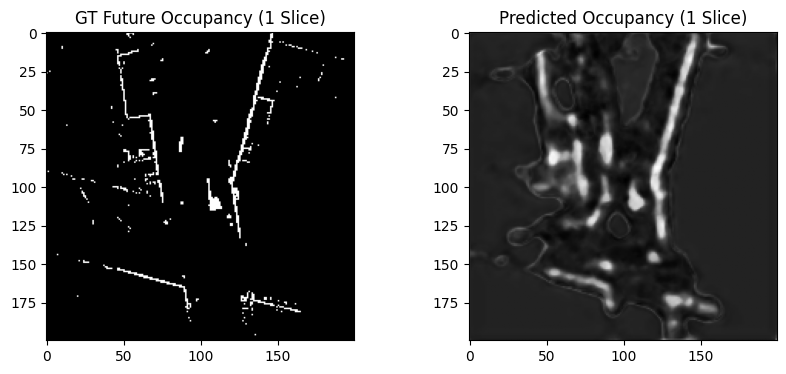

In [36]:
visualize_sample(model, val_loader, index=0)


# ConvLSTM3D Module (Temporal Fusion Layer)

In [37]:
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

ROOT = "/content/drive/MyDrive/Uniocc"
DATASET_ROOT = f"{ROOT}/datasets"
NUSC_PATH    = f"{DATASET_ROOT}/NuScenes-via-Occ3D-2Hz-mini"

CHECKPOINT_DIR = f"{ROOT}/checkpoints"
PLOTS_DIR      = f"{ROOT}/plots"

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


In [38]:
FREE_LABEL = 10

def binary_occ(x):
    return (x != FREE_LABEL).astype(np.float32)

class UniOccTemporalDataset(Dataset):
    def __init__(self, root, obs_len=4, fut_len=4):
        self.obs_len = obs_len
        self.fut_len = fut_len
        self.files = []

        for folder in sorted(os.listdir(root)):
            p = os.path.join(root, folder)
            if os.path.isdir(p):
                for f in os.listdir(p):
                    if f.endswith(".npz"):
                        self.files.append(os.path.join(p, f))
            elif p.endswith(".npz"):
                self.files.append(p)

        print(f"Found {len(self.files)} samples in {root}")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        npz = np.load(self.files[idx], allow_pickle=True)
        occ = npz["occ_label"]  # (H, W, T_grid) – using as temporal axis here

        H, W, T = occ.shape
        T_req = self.obs_len + self.fut_len
        assert T >= T_req, f"Need at least {T_req} frames, found {T}"

        # Use first obs_len as observed, next fut_len as future
        obs = occ[:, :, :self.obs_len]                     # (H, W, T_obs)
        fut = occ[:, :, self.obs_len:T_req]                # (H, W, T_fut)

        obs = binary_occ(obs)
        fut = binary_occ(fut)

        # (T, 1, H, W)
        obs = torch.tensor(obs).permute(2,0,1).unsqueeze(1).float()
        fut = torch.tensor(fut).permute(2,0,1).unsqueeze(1).float()

        return {"obs": obs, "fut": fut}


In [39]:
class ConvLSTMCell2D(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size=3, bias=True):
        super().__init__()
        padding = kernel_size // 2
        self.hidden_dim = hidden_dim

        self.conv = nn.Conv2d(
            input_dim + hidden_dim,
            4 * hidden_dim,
            kernel_size=kernel_size,
            padding=padding,
            bias=bias,
        )

    def forward(self, x, h_prev, c_prev):
        # x: (B, C_in, H, W)
        combined = torch.cat([x, h_prev], dim=1)  # (B, C_in + C_h, H, W)
        conv_out = self.conv(combined)

        i, f, o, g = torch.chunk(conv_out, 4, dim=1)

        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        o = torch.sigmoid(o)
        g = torch.tanh(g)

        c_next = f * c_prev + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next


class ConvLSTM2D(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size=3):
        super().__init__()
        self.cell = ConvLSTMCell2D(input_dim, hidden_dim, kernel_size)

    def forward(self, seq):
        """
        seq: (B, T, C, H, W)
        """
        B, T, C, H, W = seq.shape
        h = torch.zeros(B, self.cell.hidden_dim, H, W, device=seq.device)
        c = torch.zeros_like(h)

        for t in range(T):
            x_t = seq[:, t]  # (B, C, H, W)
            h, c = self.cell(x_t, h, c)

        return h  # (B, hidden_dim, H, W)


In [40]:
class TemporalOccNet(nn.Module):
    def __init__(self, obs_len=4, fut_len=4, enc_dim=32, lstm_dim=64):
        super().__init__()
        self.obs_len = obs_len
        self.fut_len = fut_len

        # Per-frame encoder: 1 → enc_dim feature maps
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.SiLU(),
            nn.Conv2d(16, enc_dim, 3, padding=1),
            nn.BatchNorm2d(enc_dim),
            nn.SiLU(),
        )

        # ConvLSTM over encoded frames
        self.temporal = ConvLSTM2D(input_dim=enc_dim, hidden_dim=lstm_dim, kernel_size=3)

        # Decoder: fuse LSTM hidden → FUT_LEN occupancy maps
        self.decoder = nn.Sequential(
            nn.Conv2d(lstm_dim, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.SiLU(),
            nn.Conv2d(32, fut_len, 1)  # output channels = T_fut
        )

    def forward(self, obs_seq):
        """
        obs_seq: (B, T_obs, 1, H, W)
        returns:  (B, T_fut, 1, H, W)
        """
        B, T, C, H, W = obs_seq.shape

        # Encode each frame
        enc_seq = []
        for t in range(T):
            x_t = obs_seq[:, t]  # (B,1,H,W)
            f_t = self.encoder(x_t)  # (B,enc_dim,H,W)
            enc_seq.append(f_t.unsqueeze(1))  # (B,1,C,H,W)

        enc_seq = torch.cat(enc_seq, dim=1)  # (B, T, C, H, W)

        # Temporal fusion
        h = self.temporal(enc_seq)  # (B, lstm_dim, H, W)

        # Decode to FUT_LEN channels
        out = self.decoder(h)  # (B, fut_len, H, W)
        out = out.unsqueeze(2)  # (B, fut_len, 1, H, W)

        return out


In [41]:
def dice_loss(logits, target, eps=1e-6):
    probs = torch.sigmoid(logits)
    probs = probs.flatten(1)
    target = target.flatten(1)

    inter = (probs * target).sum(1)
    union = probs.sum(1) + target.sum(1)
    dice = (2 * inter + eps) / (union + eps)
    return 1 - dice.mean()

POS_WEIGHT  = 20.0
BCE_WEIGHT  = 0.7
DICE_WEIGHT = 0.3

pos_w = torch.tensor([POS_WEIGHT], device=device)
bce_fn = nn.BCEWithLogitsLoss(pos_weight=pos_w)

def compute_iou(logits, target, thresh=0.5, eps=1e-6):
    probs = torch.sigmoid(logits)
    preds = (probs > thresh).float()

    inter = (preds * target).sum(dim=(1,2,3,4))
    union = ((preds + target) > 0).float().sum(dim=(1,2,3,4))

    return ((inter + eps) / (union + eps)).mean().item()


In [42]:
def train_epoch(model, loader, opt):
    model.train()
    total_loss, total_iou = 0.0, 0.0
    scaler = torch.amp.GradScaler("cuda", enabled=(device.type=="cuda"))

    bar = tqdm(loader, desc="Training", leave=False)
    for batch in bar:
        obs = batch["obs"].to(device)  # (B,T,1,H,W)
        fut = batch["fut"].to(device)  # (B,T_fut,1,H,W)

        opt.zero_grad(set_to_none=True)

        if device.type == "cuda":
            with torch.amp.autocast("cuda"):
                logits = model(obs)
                bce  = bce_fn(logits, fut)
                dloss = dice_loss(logits, fut)
                loss = BCE_WEIGHT * bce + DICE_WEIGHT * dloss
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
        else:
            logits = model(obs)
            bce  = bce_fn(logits, fut)
            dloss = dice_loss(logits, fut)
            loss = BCE_WEIGHT * bce + DICE_WEIGHT * dloss
            loss.backward()
            opt.step()

        iou = compute_iou(logits.detach(), fut)

        total_loss += loss.item()
        total_iou  += iou
        bar.set_postfix(loss=f"{loss.item():.4f}", IoU=f"{iou:.4f}")

    return total_loss / len(loader), total_iou / len(loader)


@torch.no_grad()
def val_epoch(model, loader):
    model.eval()
    total_loss, total_iou = 0.0, 0.0

    bar = tqdm(loader, desc="Validating", leave=False)
    for batch in bar:
        obs = batch["obs"].to(device)
        fut = batch["fut"].to(device)

        if device.type == "cuda":
            with torch.amp.autocast("cuda"):
                logits = model(obs)
                bce  = bce_fn(logits, fut)
                dloss = dice_loss(logits, fut)
                loss = BCE_WEIGHT * bce + DICE_WEIGHT * dloss
        else:
            logits = model(obs)
            bce  = bce_fn(logits, fut)
            dloss = dice_loss(logits, fut)
            loss = BCE_WEIGHT * bce + DICE_WEIGHT * dloss

        iou = compute_iou(logits, fut)

        total_loss += loss.item()
        total_iou  += iou
        bar.set_postfix(loss=f"{loss.item():.4f}", IoU=f"{iou:.4f}")

    return total_loss / len(loader), total_iou / len(loader)


In [43]:
OBS_LEN = 4
FUT_LEN = 4
BATCH   = 2
EPOCHS  = 10

dataset = UniOccTemporalDataset(NUSC_PATH, obs_len=OBS_LEN, fut_len=FUT_LEN)

train_len = int(0.8 * len(dataset))
val_len   = len(dataset) - train_len
train_ds, val_ds = random_split(dataset, [train_len, val_len])

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=2)

model = TemporalOccNet(obs_len=OBS_LEN, fut_len=FUT_LEN).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_losses, val_losses = [], []
train_ious,   val_ious   = [], []

best_iou = -1.0
best_path = os.path.join(CHECKPOINT_DIR, "temporal_occnet_best.pth")

for epoch in range(1, EPOCHS+1):
    tl, ti = train_epoch(model, train_loader, optimizer)
    vl, vi = val_epoch(model, val_loader)

    train_losses.append(tl)
    val_losses.append(vl)
    train_ious.append(ti)
    val_ious.append(vi)

    print(f"[Epoch {epoch}] TL={tl:.4f}, VL={vl:.4f}, TI={ti:.4f}, VI={vi:.4f}")

    if vi > best_iou:
        best_iou = vi
        torch.save(model.state_dict(), best_path)
        print(f"  ➜ New BEST temporal model saved to {best_path} (IoU={vi:.4f})")

torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, "temporal_occnet_last.pth"))
print("✓ Training complete.")


Found 404 samples in /content/drive/MyDrive/Uniocc/datasets/NuScenes-via-Occ3D-2Hz-mini


[Epoch 1] TL=1.0127, VL=0.9851, TI=0.0985, VI=0.0951
  ➜ New BEST temporal model saved to /content/drive/MyDrive/Uniocc/checkpoints/temporal_occnet_best.pth (IoU=0.0951)


[Epoch 2] TL=0.9722, VL=0.9649, TI=0.1259, VI=0.1315
  ➜ New BEST temporal model saved to /content/drive/MyDrive/Uniocc/checkpoints/temporal_occnet_best.pth (IoU=0.1315)


[Epoch 3] TL=0.9513, VL=0.9517, TI=0.1358, VI=0.1361
  ➜ New BEST temporal model saved to /content/drive/MyDrive/Uniocc/checkpoints/temporal_occnet_best.pth (IoU=0.1361)


[Epoch 4] TL=0.9335, VL=0.9452, TI=0.1410, VI=0.1410
  ➜ New BEST temporal model saved to /content/drive/MyDrive/Uniocc/checkpoints/temporal_occnet_best.pth (IoU=0.1410)


[Epoch 5] TL=0.9199, VL=0.9273, TI=0.1455, VI=0.1366


[Epoch 6] TL=0.9070, VL=0.9122, TI=0.1473, VI=0.1461
  ➜ New BEST temporal model saved to /content/drive/MyDrive/Uniocc/checkpoints/temporal_occnet_best.pth (IoU=0.1461)


[Epoch 7] TL=0.9000, VL=0.9211, TI=0.1499, VI=0.1350


[Epoch 8] TL=0.8908, VL=0.9019, TI=0.1523, VI=0.1443


[Epoch 9] TL=0.8874, VL=0.9067, TI=0.1546, VI=0.1442


[Epoch 10] TL=0.8820, VL=0.8865, TI=0.1567, VI=0.1634
  ➜ New BEST temporal model saved to /content/drive/MyDrive/Uniocc/checkpoints/temporal_occnet_best.pth (IoU=0.1634)
✓ Training complete.


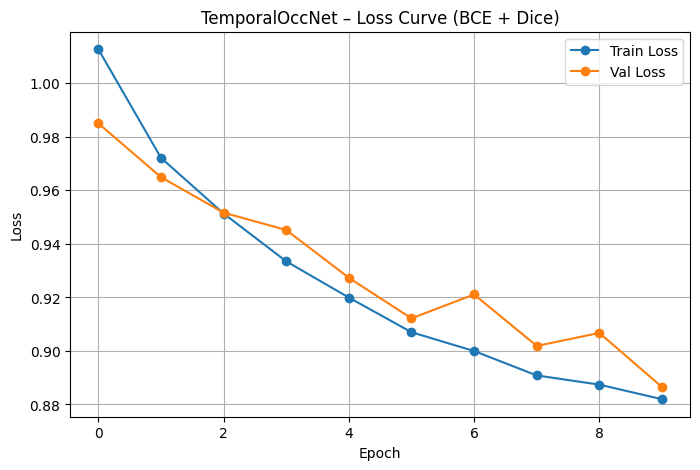

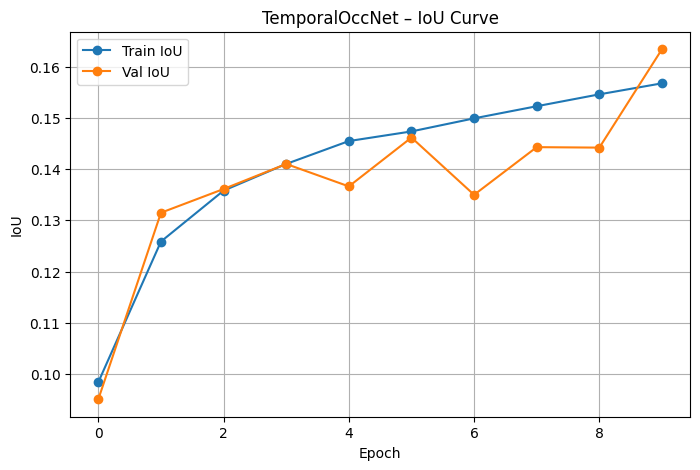

In [44]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss", marker="o")
plt.plot(val_losses,   label="Val Loss",   marker="o")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("TemporalOccNet – Loss Curve (BCE + Dice)")
plt.grid(True); plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(train_ious, label="Train IoU", marker="o")
plt.plot(val_ious,   label="Val IoU",   marker="o")
plt.xlabel("Epoch"); plt.ylabel("IoU")
plt.title("TemporalOccNet – IoU Curve")
plt.grid(True); plt.legend()
plt.show()


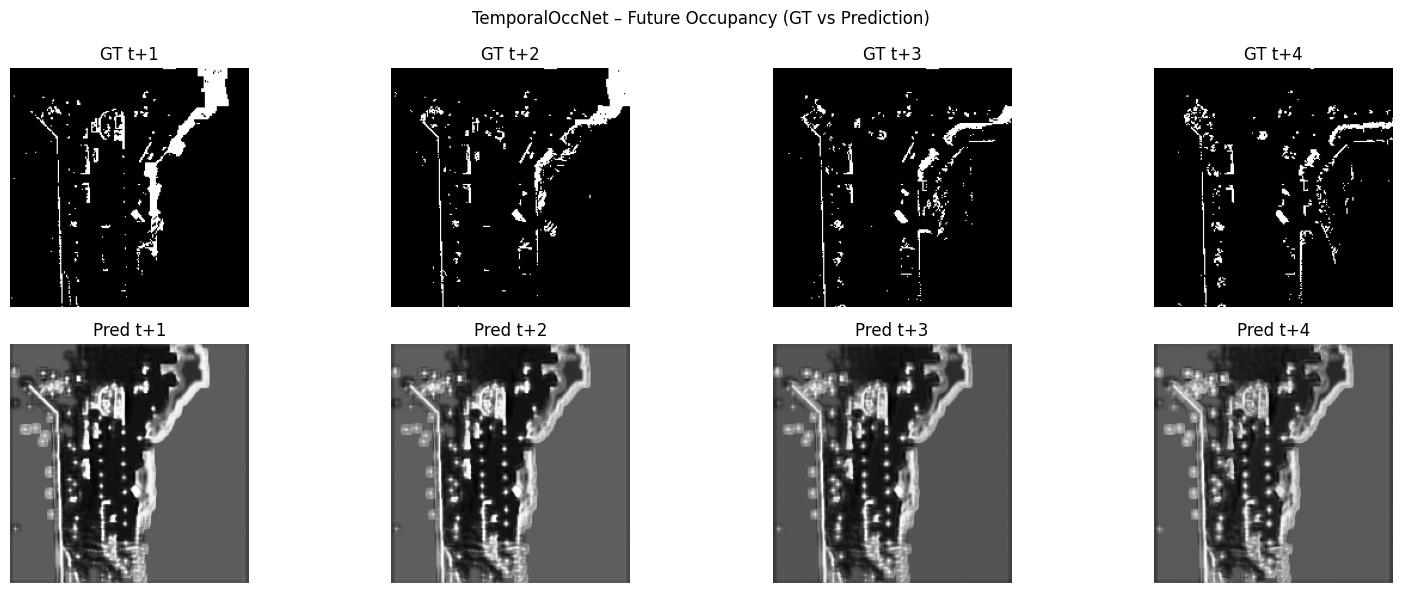

In [45]:
@torch.no_grad()
def visualize_temporal_sample(model, loader, index_in_batch=0):
    model.eval()
    batch = next(iter(loader))

    obs = batch["obs"].to(device)  # (B,T_obs,1,H,W)
    fut = batch["fut"]             # (B,T_fut,1,H,W)

    pred_logits = model(obs)
    pred = torch.sigmoid(pred_logits).cpu()

    B, T_fut, _, H, W = fut.shape

    T_show = min(T_fut, 4)  # show up to 4 future steps

    plt.figure(figsize=(4*T_show, 6))
    for t in range(T_show):
        # Ground truth
        plt.subplot(2, T_show, t+1)
        plt.imshow(fut[index_in_batch, t, 0], cmap="gray")
        plt.title(f"GT t+{t+1}")
        plt.axis("off")

        # Prediction
        plt.subplot(2, T_show, T_show + t + 1)
        plt.imshow(pred[index_in_batch, t, 0], cmap="gray")
        plt.title(f"Pred t+{t+1}")
        plt.axis("off")

    plt.suptitle("TemporalOccNet – Future Occupancy (GT vs Prediction)")
    plt.tight_layout()
    plt.show()

# Call once after training:
visualize_temporal_sample(model, val_loader, index_in_batch=0)


In [46]:
@torch.no_grad()
def visualize_temporal_sample(model, loader, index_in_batch=0, threshold=0.5):
    model.eval()
    batch = next(iter(loader))

    obs = batch["obs"].to(device)      # (B, T_obs, 1, H, W)
    fut = batch["fut"]                 # (B, T_fut, 1, H, W)

    pred_logits = model(obs)
    pred = torch.sigmoid(pred_logits).cpu()

    B, T_fut, _, H, W = fut.shape
    T_show = min(T_fut, 4)

    # --- BINARY GRIDS ---
    pred_binary = (pred > threshold).float()

    # --- METRICS ---
    intersection = (pred_binary * fut).sum().item()
    union = ((pred_binary + fut) > 0).sum().item()
    iou = intersection / (union + 1e-6)

    accuracy = (pred_binary == fut).float().mean().item()

    print(f"\n📊 Sample-Level Metrics")
    print(f"   IoU:       {iou:.4f}")
    print(f"   Accuracy:  {accuracy:.4f}")
    print("-" * 40)

    # --- Visualization ---
    plt.figure(figsize=(4 * T_show, 10))

    for t in range(T_show):

        # ------------ Ground Truth ------------
        plt.subplot(3, T_show, t+1)
        plt.imshow(fut[index_in_batch, t, 0], cmap="gray")
        plt.title(f"GT t+{t+1}")
        plt.axis("off")

        # ------------ Predicted Probability ------------
        plt.subplot(3, T_show, T_show + t + 1)
        plt.imshow(pred[index_in_batch, t, 0], cmap="viridis")
        plt.title(f"Pred Prob t+{t+1}")
        plt.axis("off")

        # ------------ Binary Prediction Grid ------------
        plt.subplot(3, T_show, 2*T_show + t + 1)
        plt.imshow(pred_binary[index_in_batch, t, 0], cmap="gray")
        plt.title(f"Pred Binary t+{t+1}")
        plt.axis("off")

    plt.suptitle("TemporalOccNet – GT vs Prediction vs Binary", fontsize=16)
    plt.tight_layout()
    plt.show()


In [47]:
@torch.no_grad()
def visualize_overlay(model, loader, index_in_batch=0, threshold=0.5):
    model.eval()
    batch = next(iter(loader))

    obs = batch["obs"].to(device)
    fut = batch["fut"]
    pred = torch.sigmoid(model(obs)).cpu()
    pred_bin = (pred > threshold).float()

    T_show = min(fut.shape[1], 4)

    plt.figure(figsize=(4*T_show, 5))

    for t in range(T_show):
        gt = fut[index_in_batch, t, 0]
        pb = pred_bin[index_in_batch, t, 0]

        overlay = np.zeros((gt.shape[0], gt.shape[1], 3))

        # TP → Green
        overlay[(gt == 1) & (pb == 1)] = [0, 1, 0]

        # FP → Red
        overlay[(gt == 0) & (pb == 1)] = [1, 0, 0]

        # FN → Blue
        overlay[(gt == 1) & (pb == 0)] = [0, 0, 1]

        plt.subplot(1, T_show, t+1)
        plt.imshow(overlay)
        plt.title(f"Overlay t+{t+1}")
        plt.axis("off")

    plt.suptitle("Prediction Error Overlay (TP/FP/FN)")
    plt.tight_layout()
    plt.show()



📊 Sample-Level Metrics
   IoU:       0.1508
   Accuracy:  0.8253
----------------------------------------


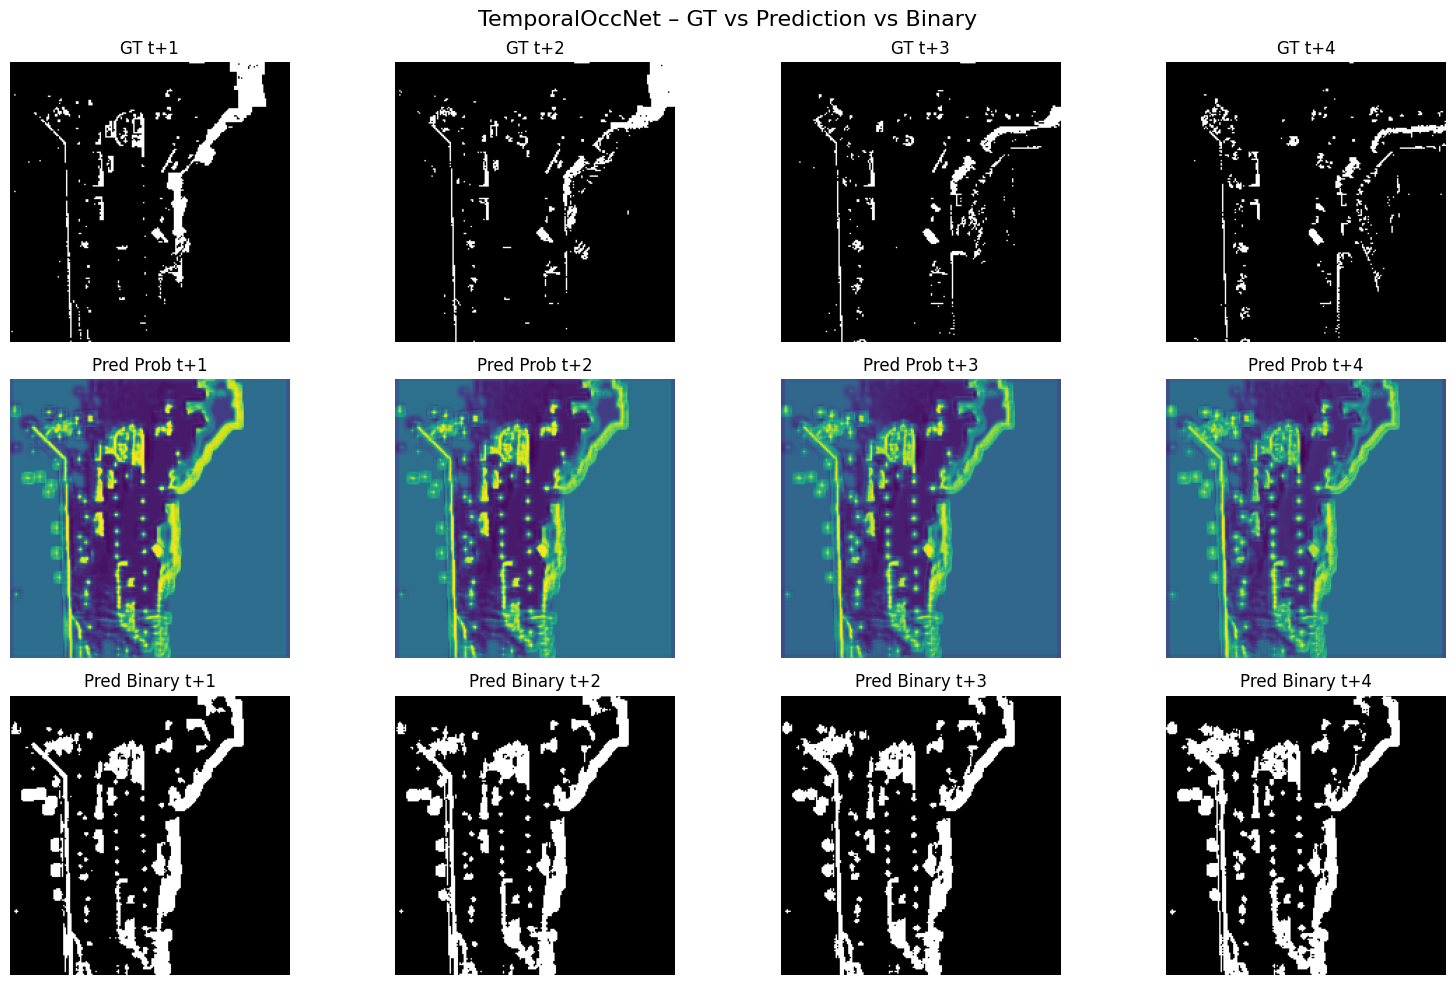

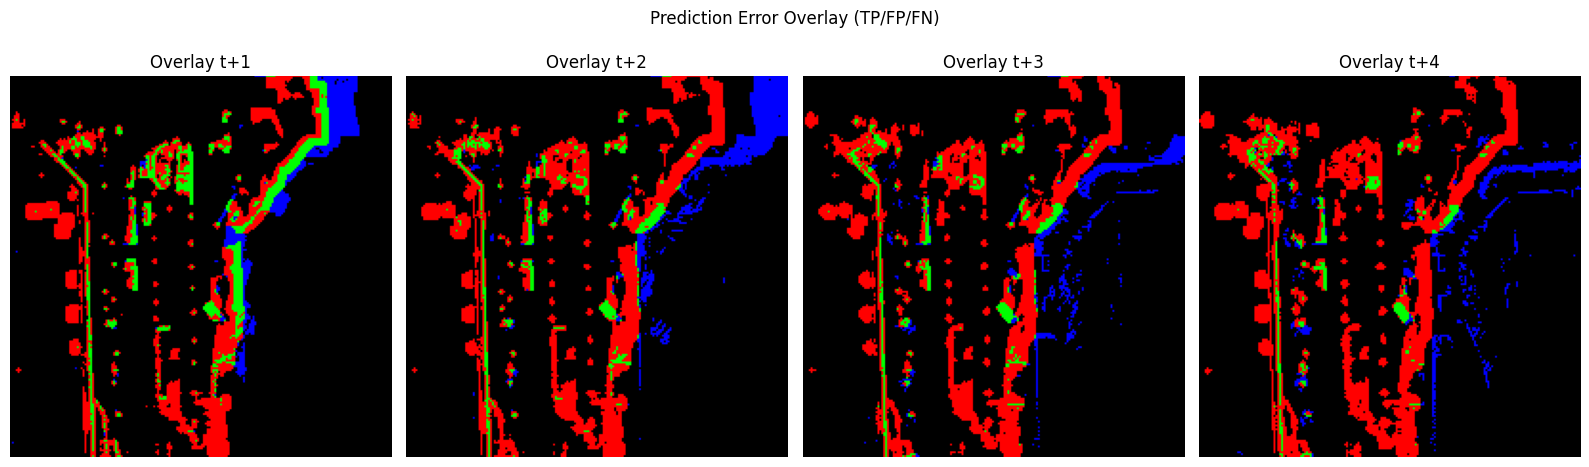

In [48]:
visualize_temporal_sample(model, val_loader)
visualize_overlay(model, val_loader)


# Step 1 — Semantic + Occupancy Dataset

#### Where:
#### 10 = free space
#### 0 = undefined / ignore
#### others = semantic classes (car, bike, pedestrian, cone, etc.)
#### From this we will derive:
#### occupancy = 1 where class ∈ {1..9, 11..19}
#### free = 0 where class = 10
#### ignore = 0 but masked out (class = 0)
#### We’ll return:
#### obs_sem (B, T_obs, H, W) – semantic class IDs
#### fut_sem (B, T_fut, H, W)
#### obs_occ (B, T_obs, 1, H, W) – binary occupancy
#### fut_occ (B, T_fut, 1, H, W)

In [49]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset

FREE_LABEL = 10
UNDEF_LABEL = 0   # ignore in loss

def make_occupancy_from_sem(sem):
    """
    sem: (H, W, T)
    Returns binary occupancy: 1 if occupied object, 0 if free or undefined.
    """
    # occupied if not free (10) and not undefined (0)
    occ = (sem != FREE_LABEL) & (sem != UNDEF_LABEL)
    return occ.astype(np.float32)


class UniOccSemanticTemporalDataset(Dataset):
    """
    Two-head dataset:
      - Semantic labels: class IDs in [0..19]
      - Occupancy labels: binary {0,1} derived from semantic
    Uses temporal slicing: first obs_len frames as input, next fut_len as target.
    """

    def __init__(self, root, obs_len=4, fut_len=4):
        super().__init__()
        self.root = root
        self.obs_len = obs_len
        self.fut_len = fut_len
        self.files = []

        for folder in sorted(os.listdir(root)):
            p = os.path.join(root, folder)
            if os.path.isdir(p):
                for f in os.listdir(p):
                    if f.endswith(".npz"):
                        self.files.append(os.path.join(p, f))
            elif p.endswith(".npz"):
                self.files.append(p)

        print(f"[UniOccSemanticTemporalDataset] Found {len(self.files)} samples in {root}")
        print(f"  obs_len={obs_len}, fut_len={fut_len}, total required frames={obs_len + fut_len}")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        npz_path = self.files[idx]
        data = np.load(npz_path, allow_pickle=True)

        # semantic labels: (H, W, T)
        sem = data["occ_label"]      # reusing your existing field
        H, W, T = sem.shape

        total_needed = self.obs_len + self.fut_len
        assert T >= total_needed, f"{npz_path}: Need {total_needed} frames, found {T}"

        # Temporal split
        sem_obs = sem[:, :, :self.obs_len]                       # (H, W, T_obs)
        sem_fut = sem[:, :, self.obs_len:total_needed]           # (H, W, T_fut)

        # Occupancy from semantic
        occ = make_occupancy_from_sem(sem)                       # (H, W, T)
        occ_obs = occ[:, :, :self.obs_len]
        occ_fut = occ[:, :, self.obs_len:total_needed]

        # Convert to tensors
        # Semantic stays as class IDs (long)
        sem_obs_t = torch.from_numpy(sem_obs).permute(2, 0, 1).long()  # (T_obs, H, W)
        sem_fut_t = torch.from_numpy(sem_fut).permute(2, 0, 1).long()  # (T_fut, H, W)

        # Occupancy as float, with channel dimension
        occ_obs_t = torch.from_numpy(occ_obs).permute(2, 0, 1).unsqueeze(1).float()  # (T_obs,1,H,W)
        occ_fut_t = torch.from_numpy(occ_fut).permute(2, 0, 1).unsqueeze(1).float()  # (T_fut,1,H,W)

        sample = {
            "sem_obs": sem_obs_t,    # (T_obs, H, W)
            "sem_fut": sem_fut_t,    # (T_fut, H, W)
            "occ_obs": occ_obs_t,    # (T_obs, 1, H, W)
            "occ_fut": occ_fut_t,    # (T_fut, 1, H, W)
            "path": npz_path,
        }
        return sample


In [50]:
from torch.utils.data import DataLoader

OBS_LEN = 4
FUT_LEN = 4

sem_dataset = UniOccSemanticTemporalDataset(
    NUSC_PATH,
    obs_len=OBS_LEN,
    fut_len=FUT_LEN
)

loader = DataLoader(sem_dataset, batch_size=2, shuffle=True)

batch = next(iter(loader))
print("sem_obs:", batch["sem_obs"].shape)   # (B, T_obs, H, W)
print("sem_fut:", batch["sem_fut"].shape)   # (B, T_fut, H, W)
print("occ_obs:", batch["occ_obs"].shape)   # (B, T_obs, 1, H, W)
print("occ_fut:", batch["occ_fut"].shape)   # (B, T_fut, 1, H, W)
print("unique sem_fut:", torch.unique(batch["sem_fut"]))


[UniOccSemanticTemporalDataset] Found 404 samples in /content/drive/MyDrive/Uniocc/datasets/NuScenes-via-Occ3D-2Hz-mini
  obs_len=4, fut_len=4, total required frames=8
sem_obs: torch.Size([2, 4, 200, 200])
sem_fut: torch.Size([2, 4, 200, 200])
occ_obs: torch.Size([2, 4, 1, 200, 200])
occ_fut: torch.Size([2, 4, 1, 200, 200])
unique sem_fut: tensor([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10])


In [51]:
import torch
import torch.nn as nn

# ---------- ConvLSTM2D building blocks ----------

class ConvLSTMCell2D(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size=3, bias=True):
        super().__init__()
        padding = kernel_size // 2
        self.hidden_dim = hidden_dim

        self.conv = nn.Conv2d(
            input_dim + hidden_dim,
            4 * hidden_dim,
            kernel_size=kernel_size,
            padding=padding,
            bias=bias,
        )

    def forward(self, x, h_prev, c_prev):
        # x: (B, C_in, H, W)
        combined = torch.cat([x, h_prev], dim=1)  # (B, C_in + C_h, H, W)
        conv_out = self.conv(combined)

        i, f, o, g = torch.chunk(conv_out, 4, dim=1)

        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        o = torch.sigmoid(o)
        g = torch.tanh(g)

        c_next = f * c_prev + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next


class ConvLSTM2D(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size=3):
        super().__init__()
        self.cell = ConvLSTMCell2D(input_dim, hidden_dim, kernel_size)

    def forward(self, seq):
        """
        seq: (B, T, C, H, W)
        returns: last hidden state h: (B, hidden_dim, H, W)
        """
        B, T, C, H, W = seq.shape
        h = torch.zeros(B, self.cell.hidden_dim, H, W, device=seq.device)
        c = torch.zeros_like(h)

        for t in range(T):
            x_t = seq[:, t]  # (B, C, H, W)
            h, c = self.cell(x_t, h, c)

        return h  # (B, hidden_dim, H, W)


# ---------- Two-Head TemporalOccNet ----------

class TwoHeadTemporalOccNet(nn.Module):
    """
    Input:
        occ_obs: (B, T_obs, 1, H, W)  # past occupancy frames

    Outputs:
        occ_logits: (B, T_fut, 1,  H, W)   # occupancy head
        sem_logits: (B, T_fut, 20, H, W)   # semantic head
    """
    def __init__(self, obs_len=4, fut_len=4, num_classes=20, enc_dim=32, lstm_dim=64):
        super().__init__()
        self.obs_len = obs_len
        self.fut_len = fut_len
        self.num_classes = num_classes

        # Per-frame encoder from 1-channel occ → enc_dim channels
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.SiLU(),
            nn.Conv2d(16, enc_dim, 3, padding=1),
            nn.BatchNorm2d(enc_dim),
            nn.SiLU(),
        )

        # Temporal fusion of encoded frames
        self.temporal = ConvLSTM2D(input_dim=enc_dim, hidden_dim=lstm_dim, kernel_size=3)

        # Occupancy head: predict T_fut * 1 channels, then reshape
        self.occ_head = nn.Sequential(
            nn.Conv2d(lstm_dim, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.SiLU(),
            nn.Conv2d(32, fut_len, 1)  # (B, T_fut, H, W)
        )

        # Semantic head: predict T_fut * num_classes channels, then reshape
        self.sem_head = nn.Sequential(
            nn.Conv2d(lstm_dim, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.SiLU(),
            nn.Conv2d(64, fut_len * num_classes, 1)  # (B, T_fut * C, H, W)
        )

    def forward(self, occ_obs):
        """
        occ_obs: (B, T_obs, 1, H, W)
        """
        B, T, C, H, W = occ_obs.shape
        assert T == self.obs_len, f"Expected T_obs={self.obs_len}, got {T}"

        # Encode each observed frame
        enc_seq = []
        for t in range(T):
            x_t = occ_obs[:, t]         # (B,1,H,W)
            f_t = self.encoder(x_t)     # (B,enc_dim,H,W)
            enc_seq.append(f_t.unsqueeze(1))  # (B,1,C,H,W)

        enc_seq = torch.cat(enc_seq, dim=1)   # (B,T,enc_dim,H,W)

        # Temporal fusion
        h = self.temporal(enc_seq)            # (B,lstm_dim,H,W)

        # Occupancy head
        occ_logits = self.occ_head(h)         # (B,T_fut,H,W)
        occ_logits = occ_logits.unsqueeze(2)  # (B,T_fut,1,H,W)

        # Semantic head
        sem_logits = self.sem_head(h)         # (B,T_fut * C,H,W)
        sem_logits = sem_logits.view(
            B, self.fut_len, self.num_classes, H, W
        )                                     # (B,T_fut,C,H,W)

        return occ_logits, sem_logits


In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

OBS_LEN = 4
FUT_LEN = 4
NUM_CLASSES = 20

model = TwoHeadTemporalOccNet(
    obs_len=OBS_LEN,
    fut_len=FUT_LEN,
    num_classes=NUM_CLASSES,
    enc_dim=32,
    lstm_dim=64
).to(device)

# Use the semantic+occ dataset we already built
from torch.utils.data import DataLoader

sem_dataset = sem_dataset  # already created earlier
sem_loader  = DataLoader(sem_dataset, batch_size=2, shuffle=True)

batch = next(iter(sem_loader))

occ_obs = batch["occ_obs"].to(device)   # (B,T_obs,1,H,W)
sem_fut = batch["sem_fut"]              # (B,T_fut,H,W)
occ_fut = batch["occ_fut"]              # (B,T_fut,1,H,W)

with torch.no_grad():
    occ_logits, sem_logits = model(occ_obs)

print("occ_logits shape:", occ_logits.shape)   # (B,T_fut,1,H,W)
print("sem_logits shape:", sem_logits.shape)   # (B,T_fut,20,H,W)
print("GT occ_fut shape:", occ_fut.shape)
print("GT sem_fut shape:", sem_fut.shape)

# Parameter count
n_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {n_params/1e6:.3f} M")


Using device: cuda
occ_logits shape: torch.Size([2, 4, 1, 200, 200])
sem_logits shape: torch.Size([2, 4, 20, 200, 200])
GT occ_fut shape: torch.Size([2, 4, 1, 200, 200])
GT sem_fut shape: torch.Size([2, 4, 200, 200])
Total parameters: 0.287 M


In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------- Dice Loss for Occupancy ----------
def dice_loss(pred, target, eps=1e-6):
    """
    pred, target: (B, T, 1, H, W) after sigmoid
    """
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)

    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()

    dice = (2.0 * intersection + eps) / (union + eps)
    return 1 - dice


# ---------- Combined Occupancy Loss ----------
def occupancy_loss(occ_logits, occ_fut):
    """
    occ_logits: raw logits (no sigmoid yet)
    occ_fut: binary GT (0/1)
    """
    bce = F.binary_cross_entropy_with_logits(occ_logits, occ_fut)
    dice = dice_loss(torch.sigmoid(occ_logits), occ_fut)
    return bce + dice


# ---------- Semantic CE Loss ----------
def semantic_loss(sem_logits, sem_fut, ignore_index=0):
    """
    sem_logits: (B,T,C,H,W)
    sem_fut:    (B,T,H,W)  class IDs
    """
    B, T, C, H, W = sem_logits.shape

    # collapse time dimension for CE
    logits = sem_logits.view(B*T, C, H, W)
    target = sem_fut.view(B*T, H, W)

    return F.cross_entropy(
        logits,
        target,
        ignore_index=ignore_index   # ignore undefined
    )


In [54]:
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_occ_loss = 0
    total_sem_loss = 0

    for batch in loader:
        occ_obs = batch["occ_obs"].to(device)   # (B,T_obs,1,H,W)
        occ_fut = batch["occ_fut"].to(device)   # (B,T_fut,1,H,W)
        sem_fut = batch["sem_fut"].to(device)   # (B,T_fut,H,W)

        optimizer.zero_grad()

        with autocast():
            occ_logits, sem_logits = model(occ_obs)

            loss_occ = occupancy_loss(occ_logits, occ_fut)
            loss_sem = semantic_loss(sem_logits, sem_fut)

            loss = loss_occ + loss_sem   # 1:1 weighting for now

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_occ_loss += loss_occ.item()
        total_sem_loss += loss_sem.item()

    return total_occ_loss / len(loader), total_sem_loss / len(loader)


@torch.no_grad()
def eval_one_epoch(model, loader, device):
    model.eval()
    total_occ_loss = 0
    total_sem_loss = 0

    for batch in loader:
        occ_obs = batch["occ_obs"].to(device)
        occ_fut = batch["occ_fut"].to(device)
        sem_fut = batch["sem_fut"].to(device)

        occ_logits, sem_logits = model(occ_obs)

        loss_occ = occupancy_loss(occ_logits, occ_fut)
        loss_sem = semantic_loss(sem_logits, sem_fut)

        total_occ_loss += loss_occ.item()
        total_sem_loss += loss_sem.item()

    return total_occ_loss / len(loader), total_sem_loss / len(loader)


/tmp/ipython-input-1259035004.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [55]:
from torch.utils.data import DataLoader

OBS_LEN = 4
FUT_LEN = 4
BATCH = 2
EPOCHS = 5
LR = 1e-4

train_loader = DataLoader(sem_dataset, batch_size=BATCH, shuffle=True, num_workers=2)

model = TwoHeadTemporalOccNet(
    obs_len=OBS_LEN,
    fut_len=FUT_LEN,
    num_classes=20
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print("Starting training...")

for epoch in range(1, EPOCHS+1):
    tr_occ, tr_sem = train_one_epoch(model, train_loader, optimizer, device)
    val_occ, val_sem = eval_one_epoch(model, train_loader, device)

    print(f"[Epoch {epoch:02d}] "
          f"Occ Loss: train={tr_occ:.4f}, val={val_occ:.4f} | "
          f"Sem Loss: train={tr_sem:.4f}, val={val_sem:.4f}")

# save weights
torch.save(model.state_dict(), f"{CHECKPOINT_DIR}/two_head_temporal_best.pth")
print("✅ Saved!")


Starting training...


/tmp/ipython-input-1259035004.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Epoch 01] Occ Loss: train=1.5608, val=1.5154 | Sem Loss: train=2.5991, val=2.1552
[Epoch 02] Occ Loss: train=1.4840, val=1.4475 | Sem Loss: train=2.0143, val=1.7303
[Epoch 03] Occ Loss: train=1.4163, val=1.3911 | Sem Loss: train=1.4324, val=1.2042
[Epoch 04] Occ Loss: train=1.3418, val=1.3115 | Sem Loss: train=0.9433, val=0.6883
[Epoch 05] Occ Loss: train=1.2690, val=1.2385 | Sem Loss: train=0.6126, val=0.5110
✅ Saved!


In [56]:
import numpy as np

# Match your existing COLOR_MAP indices
CLASS_NAMES = {
    0:  "undefined",
    1:  "car",
    2:  "bicycle",
    3:  "motorcycle",
    4:  "pedestrian",
    5:  "traffic_cone",
    6:  "vegetation",
    7:  "road",
    8:  "terrain",
    9:  "building",
    10: "free",
    11: "class_11",
    12: "reserved_12",
    13: "reserved_13",
    14: "reserved_14",
    15: "reserved_15",
    16: "reserved_16",
    17: "reserved_17",
    18: "reserved_18",
    19: "reserved_19",
}

DYNAMIC_CLASSES = [1, 2, 3, 4, 5]  # vehicles, bikes, peds, cones
STATIC_CLASSES  = [6, 7, 8, 9, 10]


In [57]:
@torch.no_grad()
def compute_occupancy_iou(model, loader, device, threshold=0.5):
    model.eval()
    inter_total = 0.0
    union_total = 0.0

    for batch in loader:
        occ_obs = batch["occ_obs"].to(device)   # (B,T_obs,1,H,W)
        occ_fut = batch["occ_fut"].to(device)   # (B,T_fut,1,H,W)

        occ_logits, _ = model(occ_obs)          # (B,T_fut,1,H,W)
        probs = torch.sigmoid(occ_logits)
        preds = (probs > threshold).float()

        intersection = (preds * occ_fut).sum().item()
        union = ((preds + occ_fut) > 0).float().sum().item()

        inter_total += intersection
        union_total += union

    iou = inter_total / (union_total + 1e-6)
    return iou


In [60]:
@torch.no_grad()
def compute_semantic_iou(model, loader, device, num_classes=20):
    model.eval()

    # Allocate accumulators ON THE SAME DEVICE
    inter = torch.zeros(num_classes, dtype=torch.float64, device=device)
    union = torch.zeros(num_classes, dtype=torch.float64, device=device)

    for batch in loader:
        occ_obs = batch["occ_obs"].to(device)   # (B,T_obs,1,H,W)
        sem_fut = batch["sem_fut"].to(device)   # (B,T_fut,H,W)

        # Forward
        _, sem_logits = model(occ_obs)          # (B,T_fut,C,H,W)
        sem_pred = sem_logits.argmax(dim=2)     # (B,T_fut,H,W)

        # Flatten
        sem_pred_flat = sem_pred.view(-1)
        sem_fut_flat  = sem_fut.view(-1)

        # Ignore undefined=0
        valid_mask = (sem_fut_flat != 0)

        sem_pred_valid = sem_pred_flat[valid_mask]
        sem_fut_valid  = sem_fut_flat[valid_mask]

        # Accumulate IoU stats
        for cls in range(1, num_classes):
            pred_c = (sem_pred_valid == cls)
            gt_c   = (sem_fut_valid == cls)

            inter_c = (pred_c & gt_c).sum()
            union_c = (pred_c | gt_c).sum()

            inter[cls] += inter_c
            union[cls] += union_c

    # Move to CPU for reporting
    inter = inter.cpu()
    union = union.cpu()

    # Compute IoUs
    iou_per_class = {}
    for cls in range(1, num_classes):
        if union[cls] > 0:
            iou_per_class[cls] = (inter[cls] / (union[cls] + 1e-6)).item()
        else:
            iou_per_class[cls] = float("nan")

    valid_ious = [v for v in iou_per_class.values() if not np.isnan(v)]
    mean_iou = float(np.mean(valid_ious)) if valid_ious else float("nan")

    dyn_ious = [iou_per_class[c] for c in DYNAMIC_CLASSES if c in iou_per_class and not np.isnan(iou_per_class[c])]
    dyn_miou = float(np.mean(dyn_ious)) if dyn_ious else float("nan")

    stat_ious = [iou_per_class[c] for c in STATIC_CLASSES if c in iou_per_class and not np.isnan(iou_per_class[c])]
    stat_miou = float(np.mean(stat_ious)) if stat_ious else float("nan")

    return iou_per_class, mean_iou, dyn_miou, stat_miou


In [61]:
eval_loader = DataLoader(sem_dataset, batch_size=2, shuffle=False, num_workers=2)

occ_iou = compute_occupancy_iou(model, eval_loader, device)
sem_iou_cls, sem_miou, dyn_miou, stat_miou = compute_semantic_iou(model, eval_loader, device, num_classes=20)

print("\n=== OCCUPANCY METRIC ===")
print(f"Overall Occupancy IoU: {occ_iou:.4f}")

print("\n=== SEMANTIC PER-CLASS IoU ===")
for cls_id, iou_val in sem_iou_cls.items():
    if np.isnan(iou_val):
        continue
    name = CLASS_NAMES.get(cls_id, f"class_{cls_id}")
    print(f"  Class {cls_id:2d} ({name:12s}): IoU = {iou_val:.4f}")

print("\n=== SEMANTIC SUMMARY ===")
print(f"  Mean IoU (all foreground classes): {sem_miou:.4f}")
print(f"  Mean IoU (dynamic classes {DYNAMIC_CLASSES}): {dyn_miou:.4f}")
print(f"  Mean IoU (static classes  {STATIC_CLASSES}): {stat_miou:.4f}")



=== OCCUPANCY METRIC ===
Overall Occupancy IoU: 0.2399

=== SEMANTIC PER-CLASS IoU ===
  Class  1 (car         ): IoU = 0.1707
  Class  2 (bicycle     ): IoU = 0.0000
  Class  3 (motorcycle  ): IoU = 0.0000
  Class  4 (pedestrian  ): IoU = 0.0000
  Class  5 (traffic_cone): IoU = 0.0000
  Class  6 (vegetation  ): IoU = 0.0000
  Class  7 (road        ): IoU = 0.0000
  Class  8 (terrain     ): IoU = 0.0000
  Class  9 (building    ): IoU = 0.1600
  Class 10 (free        ): IoU = 0.9572

=== SEMANTIC SUMMARY ===
  Mean IoU (all foreground classes): 0.1288
  Mean IoU (dynamic classes [1, 2, 3, 4, 5]): 0.0341
  Mean IoU (static classes  [6, 7, 8, 9, 10]): 0.2234


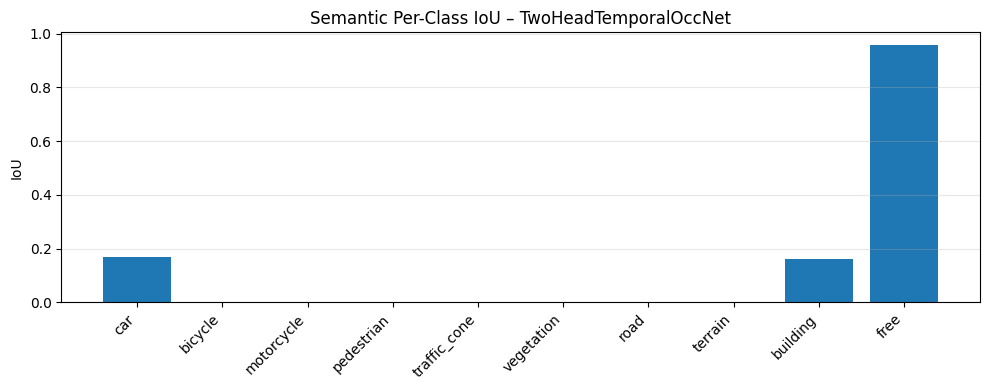

In [62]:
import matplotlib.pyplot as plt

# Filter out NaNs and undefined
cls_ids = sorted([c for c, v in sem_iou_cls.items() if not np.isnan(v)])
ious = [sem_iou_cls[c] for c in cls_ids]
names = [CLASS_NAMES.get(c, str(c)) for c in cls_ids]

plt.figure(figsize=(10,4))
plt.bar(range(len(cls_ids)), ious)
plt.xticks(range(len(cls_ids)), names, rotation=45, ha="right")
plt.ylabel("IoU")
plt.title("Semantic Per-Class IoU – TwoHeadTemporalOccNet")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


# Implement Balanced Semantic Loss

In [63]:
import numpy as np
from tqdm import tqdm
import torch

def compute_class_frequency(dataset, num_classes=20):
    freq = np.zeros(num_classes, dtype=np.int64)

    for i in tqdm(range(len(dataset)), desc="Computing class frequencies"):
        sample = dataset[i]
        sem_fut = sample["sem_fut"]  # (T,H,W)

        for t in range(sem_fut.shape[0]):
            labels = sem_fut[t].numpy().flatten()
            for c in range(num_classes):
                freq[c] += np.sum(labels == c)

    return freq

# Run once
class_freq = compute_class_frequency(sem_dataset, num_classes=20)
print("Class frequencies:\n", class_freq)


Computing class frequencies: 100%|██████████| 404/404 [00:07<00:00, 57.01it/s]

Class frequencies:
 [    9252   567235     3699    11031    55374     2184   831193   163477
   205523  1153237 61637795        0        0        0        0        0
        0        0        0        0]


In [64]:
def compute_class_weights(freq, eps=1e-6):
    inv = 1.0 / (freq + eps)
    weights = inv / inv.sum() * len(freq)    # normalize
    return torch.tensor(weights, dtype=torch.float32)

class_weights = compute_class_weights(class_freq).cuda()
print("Class Weights:\n", class_weights)


Class Weights:
 tensor([2.4019e-10, 3.9176e-12, 6.0076e-10, 2.0145e-10, 4.0131e-11, 1.0175e-09,
        2.6735e-12, 1.3593e-11, 1.0813e-11, 1.9269e-12, 3.6053e-14, 2.2222e+00,
        2.2222e+00, 2.2222e+00, 2.2222e+00, 2.2222e+00, 2.2222e+00, 2.2222e+00,
        2.2222e+00, 2.2222e+00], device='cuda:0')


In [68]:
class BalancedSemanticLoss(nn.Module):
    def __init__(self, class_weights, gamma=2.0):
        super().__init__()
        self.class_weights = class_weights
        self.gamma = gamma

    def forward(self, logits, target):
        # logits: (B, T, C, H, W)
        # target: (B, T, H, W)

        B, T, C, H, W = logits.shape

        logits = logits.permute(0,1,3,4,2).reshape(-1, C)  # (B*T*H*W, C)
        target = target.reshape(-1).long().to(logits.device)

        ce = F.cross_entropy(
            logits,
            target,
            weight=self.class_weights,
            reduction="none"
        )

        pt = torch.exp(-ce)
        focal = (1 - pt) ** self.gamma * ce

        return focal.mean()


In [71]:
from torch.nn import BCEWithLogitsLoss

occ_loss_fn = BCEWithLogitsLoss()

class_weights = class_weights.to(device)  # ✅ move to CUDA
sem_loss_fn = BalancedSemanticLoss(class_weights)


In [72]:
for epoch in range(1, EPOCHS + 1):
    model.train()
    train_occ_loss = 0.0
    train_sem_loss = 0.0

    for batch in train_loader:
        obs = batch["occ_obs"].to(device)   # (B,T,1,H,W)
        fut_occ = batch["occ_fut"].to(device)
        fut_sem = batch["sem_fut"].to(device)  # ✅ moved to device

        optimizer.zero_grad()

        with autocast():
            occ_logits, sem_logits = model(obs)

            # Occupancy BCE loss
            occ_loss = occ_loss_fn(occ_logits, fut_occ)

            # ✅ Semantic loss
            sem_loss = sem_loss_fn(sem_logits, fut_sem)

            # ✅ balanced total loss
            total_loss = occ_loss + 0.5 * sem_loss

        scaler.scale(total_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_occ_loss += occ_loss.item()
        train_sem_loss += sem_loss.item()

    print(f"[Epoch {epoch:02d}] Train Occ={train_occ_loss:.4f} | Train Sem={train_sem_loss:.4f}")

print("✅ Training Complete with BALANCED SEM LOSS!")


/tmp/ipython-input-2384184463.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Epoch 01] Train Occ=70.2364 | Train Sem=0.0000
[Epoch 02] Train Occ=61.4566 | Train Sem=0.0000
[Epoch 03] Train Occ=54.1239 | Train Sem=0.0000
[Epoch 04] Train Occ=48.3719 | Train Sem=0.0000
[Epoch 05] Train Occ=43.4540 | Train Sem=0.0000
✅ Training Complete with BALANCED SEM LOSS!


In [73]:
# ===== Re-Evaluation =====
eval_loader = DataLoader(sem_dataset, batch_size=2, shuffle=False, num_workers=2)

# Occupancy IoU
occ_iou = compute_occupancy_iou(model, eval_loader, device)

# Semantic IoU
sem_iou_cls, sem_miou, dyn_miou, stat_miou = compute_semantic_iou(
    model,
    eval_loader,
    device,
    num_classes=20
)

print("\n=== OCCUPANCY METRIC ===")
print(f"Overall Occupancy IoU: {occ_iou:.4f}")

print("\n=== SEMANTIC PER-CLASS IoU ===")
for cls_id, iou_val in sem_iou_cls.items():
    if np.isnan(iou_val):
        continue
    name = CLASS_NAMES.get(cls_id, f"class_{cls_id}")
    print(f"  Class {cls_id:2d} ({name:12s}): IoU = {iou_val:.4f}")

print("\n=== SEMANTIC SUMMARY ===")
print(f"  Mean IoU (all foreground classes): {sem_miou:.4f}")
print(f"  Mean IoU (dynamic classes): {dyn_miou:.4f}")
print(f"  Mean IoU (static  classes): {stat_miou:.4f}")



=== OCCUPANCY METRIC ===
Overall Occupancy IoU: 0.1891

=== SEMANTIC PER-CLASS IoU ===
  Class  1 (car         ): IoU = 0.1209
  Class  2 (bicycle     ): IoU = 0.0000
  Class  3 (motorcycle  ): IoU = 0.0000
  Class  4 (pedestrian  ): IoU = 0.0000
  Class  5 (traffic_cone): IoU = 0.0000
  Class  6 (vegetation  ): IoU = 0.0000
  Class  7 (road        ): IoU = 0.0000
  Class  8 (terrain     ): IoU = 0.0000
  Class  9 (building    ): IoU = 0.1295
  Class 10 (free        ): IoU = 0.9570

=== SEMANTIC SUMMARY ===
  Mean IoU (all foreground classes): 0.1207
  Mean IoU (dynamic classes): 0.0242
  Mean IoU (static  classes): 0.2173


In [74]:
import numpy as np
import torch

def compute_class_weights(freq, dynamic_classes=[1,2,3,4,5], boost_dyn=2.0, eps=1e-6):
    """
    freq: np.array of shape (num_classes,)
    dynamic_classes: ids to boost (cars/bikes/peds/cones)
    boost_dyn: how much to upweight dynamic classes
    """
    freq = freq.astype(np.float64)

    # mask for classes that actually appear
    valid = freq > 0

    inv = np.zeros_like(freq, dtype=np.float64)
    inv[valid] = 1.0 / (freq[valid] + eps)

    # normalize over valid classes only
    inv_valid_sum = inv[valid].sum()
    if inv_valid_sum > 0:
        inv[valid] = inv[valid] / inv_valid_sum * valid.sum()

    # boost dynamic classes a bit more
    for cls in dynamic_classes:
        if cls < len(inv) and valid[cls]:
            inv[cls] *= boost_dyn

    # re-normalize after boosting
    inv_valid_sum = inv[valid].sum()
    if inv_valid_sum > 0:
        inv[valid] = inv[valid] / inv_valid_sum * valid.sum()

    return torch.tensor(inv, dtype=torch.float32)

# recompute weights
class_weights = compute_class_weights(class_freq, dynamic_classes=[1,2,3,4,5], boost_dyn=2.0).to(device)
print("Fixed Class Weights:\n", class_weights)


Fixed Class Weights:
 tensor([6.6105e-01, 2.1564e-02, 3.3069e+00, 1.1089e+00, 2.2090e-01, 5.6008e+00,
        7.3582e-03, 3.7412e-02, 2.9759e-02, 5.3034e-03, 9.9226e-05, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00], device='cuda:0')


In [75]:
sem_loss_fn = BalancedSemanticLoss(class_weights)


In [76]:
from tqdm import tqdm
import numpy as np

RARE_CLASSES = [2, 3, 4, 5]  # bicycle, motorcycle, pedestrian, traffic_cone

def compute_sample_rare_flags(dataset, rare_classes=RARE_CLASSES):
    """
    Returns: np.array of shape (N,) with 1 if sample contains any rare class, else 0
    """
    rare_flags = np.zeros(len(dataset), dtype=np.int32)

    for idx in tqdm(range(len(dataset)), desc="Scanning dataset for rare-class presence"):
        sample = dataset[idx]
        sem_fut = sample["sem_fut"]   # (T,H,W) tensor

        sem_np = sem_fut.numpy()
        mask = np.isin(sem_np, rare_classes)
        rare_flags[idx] = int(mask.any())

    return rare_flags

# if you're just using sem_dataset as train:
train_dataset = sem_dataset

rare_flags = compute_sample_rare_flags(train_dataset, rare_classes=RARE_CLASSES)
print("Num samples with rare classes:", rare_flags.sum(), "/", len(rare_flags))


Scanning dataset for rare-class presence: 100%|██████████| 404/404 [00:05<00:00, 73.54it/s]

Num samples with rare classes: 338 / 404


In [78]:
from torch.utils.data import DataLoader, WeightedRandomSampler

def build_rare_aware_sampler(rare_flags, rare_factor=5.0):
    """
    rare_flags: np.array (N,), 1 if sample has rare class(es)
    rare_factor: weight multiplier for rare samples
    """
    base = np.ones_like(rare_flags, dtype=np.float32)
    weights = base.copy()
    weights[rare_flags == 1] *= rare_factor

    # normalize to avoid numerical issues (optional)
    weights = weights / weights.sum()

    return WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

sampler = build_rare_aware_sampler(rare_flags, rare_factor=5.0)

train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    sampler=sampler,        # 🔥 replaces shuffle=True
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    train_dataset,  # or val_dataset if you have a split
    batch_size=2,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)



In [79]:
for epoch in range(1, EPOCHS + 1):
    model.train()
    train_occ_loss = 0.0
    train_sem_loss = 0.0

    for batch in train_loader:   # <- now rare-aware
        obs      = batch["occ_obs"].to(device)
        fut_occ  = batch["occ_fut"].to(device)
        fut_sem  = batch["sem_fut"].to(device)

        optimizer.zero_grad()

        with autocast():
            occ_logits, sem_logits = model(obs)

            occ_loss = occ_loss_fn(occ_logits, fut_occ)
            sem_loss = sem_loss_fn(sem_logits, fut_sem)

            total_loss = occ_loss + 0.5 * sem_loss

        scaler.scale(total_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_occ_loss += occ_loss.item()
        train_sem_loss += sem_loss.item()

    print(f"[Epoch {epoch:02d}] Train Occ={train_occ_loss:.4f} | Train Sem={train_sem_loss:.4f}")


/tmp/ipython-input-2570726540.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Epoch 01] Train Occ=40.3332 | Train Sem=0.6460
[Epoch 02] Train Occ=37.0550 | Train Sem=0.5639
[Epoch 03] Train Occ=35.2145 | Train Sem=0.5834
[Epoch 04] Train Occ=33.1477 | Train Sem=0.5407
[Epoch 05] Train Occ=32.1913 | Train Sem=0.5776


In [80]:
occ_iou = compute_occupancy_iou(model, val_loader, device)

sem_iou_cls, sem_miou, dyn_miou, stat_miou = compute_semantic_iou(model, val_loader, device, num_classes=20)


In [81]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import random

FREE_LABEL = 10

COLOR_MAP = np.array([
    [255, 255, 255, 255],   # 0 undefined       white
    [0, 150, 245, 255],     # 1 car             blue
    [255, 192, 203, 255],   # 2 bicycle         pink
    [200, 180, 0, 255],     # 3 motorcycle      dark orange
    [255, 0, 0, 255],       # 4 pedestrian      red
    [255, 240, 150, 255],   # 5 traffic_cone    light yellow
    [0, 175, 0, 255],       # 6 vegetation      green
    [255, 0, 255, 255],     # 7 road            dark pink
    [0, 175, 0, 255],       # 8 terrain         green
    [230, 230, 250, 255],   # 9 building        white
    [0, 0, 0, 0],           # 10 free           black
    [128, 128, 128, 255],   # 11
    [211, 211, 211, 255],   # 12 reserved       gray
    [120, 200, 255, 255],   # 13 reserved       light blue
    [255, 220, 230, 255],   # 14 reserved       light pink
    [120, 200, 255, 255],   # 15 reserved       light orange
    [255, 100, 100, 255],   # 16 reserved       light red
    [255, 245, 190, 255],   # 17 reserved       light yellow
    [100, 220, 100, 255],   # 18 reserved       light green
    [255, 100, 255, 255],   # 19 reserved       light magenta
], dtype=np.float32)


In [82]:
train_occ_hist, train_sem_hist = [], []
# if you have val metrics later:
val_occ_hist, val_sem_hist = [], []


In [84]:
from torch.amp import autocast, GradScaler

EPOCHS = 10
train_occ_hist, train_sem_hist = [], []
val_occ_hist, val_sem_hist = [], []

scaler = GradScaler('cuda')

print("\n🚀 Starting Training...\n")

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_occ, running_sem = 0.0, 0.0

    for batch in train_loader:
        # ✅ Correct keys
        occ_obs = batch["occ_obs"].to(device)      # (B,T,1,H,W)
        fut_occ = batch["occ_fut"].to(device)      # (B,T,1,H,W)
        fut_sem = batch["sem_fut"].to(device)      # (B,T,H,W)

        optimizer.zero_grad()

        with autocast('cuda'):
            # ✅ Input is occupancy observations
            occ_logits, sem_logits = model(occ_obs)

            # ✅ Losses
            occ_loss = occ_loss_fn(occ_logits, fut_occ)
            sem_loss = sem_loss_fn(sem_logits, fut_sem)

            total_loss = occ_loss + 0.5 * sem_loss

        scaler.scale(total_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_occ += occ_loss.item()
        running_sem += sem_loss.item()

    # ✅ Training epoch averages
    avg_train_occ = running_occ / len(train_loader)
    avg_train_sem = running_sem / len(train_loader)

    train_occ_hist.append(avg_train_occ)
    train_sem_hist.append(avg_train_sem)

    # ✅ Validation
    model.eval()
    with torch.no_grad():
        val_occ, val_sem = 0.0, 0.0

        for batch in val_loader:
            occ_obs = batch["occ_obs"].to(device)
            fut_occ = batch["occ_fut"].to(device)
            fut_sem = batch["sem_fut"].to(device)

            occ_logits, sem_logits = model(occ_obs)

            val_occ += occ_loss_fn(occ_logits, fut_occ).item()
            val_sem += sem_loss_fn(sem_logits, fut_sem).item()

        avg_val_occ = val_occ / len(val_loader)
        avg_val_sem = val_sem / len(val_loader)

        val_occ_hist.append(avg_val_occ)
        val_sem_hist.append(avg_val_sem)

    print(f"[Epoch {epoch:02d}] "
          f"Train Occ={avg_train_occ:.4f} | Train Sem={avg_train_sem:.4f} || "
          f"Val Occ={avg_val_occ:.4f} | Val Sem={avg_val_sem:.4f}")

print("\n✅ Training Complete!")



🚀 Starting Training...

[Epoch 01] Train Occ=0.1547 | Train Sem=0.0028 || Val Occ=0.1510 | Val Sem=0.0022
[Epoch 02] Train Occ=0.1484 | Train Sem=0.0025 || Val Occ=0.1527 | Val Sem=0.0022
[Epoch 03] Train Occ=0.1428 | Train Sem=0.0025 || Val Occ=0.1453 | Val Sem=0.0021
[Epoch 04] Train Occ=0.1446 | Train Sem=0.0025 || Val Occ=0.1507 | Val Sem=0.0020
[Epoch 05] Train Occ=0.1417 | Train Sem=0.0023 || Val Occ=0.1408 | Val Sem=0.0020
[Epoch 06] Train Occ=0.1391 | Train Sem=0.0022 || Val Occ=0.1391 | Val Sem=0.0019
[Epoch 07] Train Occ=0.1415 | Train Sem=0.0023 || Val Occ=0.1386 | Val Sem=0.0019
[Epoch 08] Train Occ=0.1397 | Train Sem=0.0021 || Val Occ=0.1407 | Val Sem=0.0018
[Epoch 09] Train Occ=0.1376 | Train Sem=0.0021 || Val Occ=0.1382 | Val Sem=0.0017
[Epoch 10] Train Occ=0.1404 | Train Sem=0.0020 || Val Occ=0.1375 | Val Sem=0.0017

✅ Training Complete!


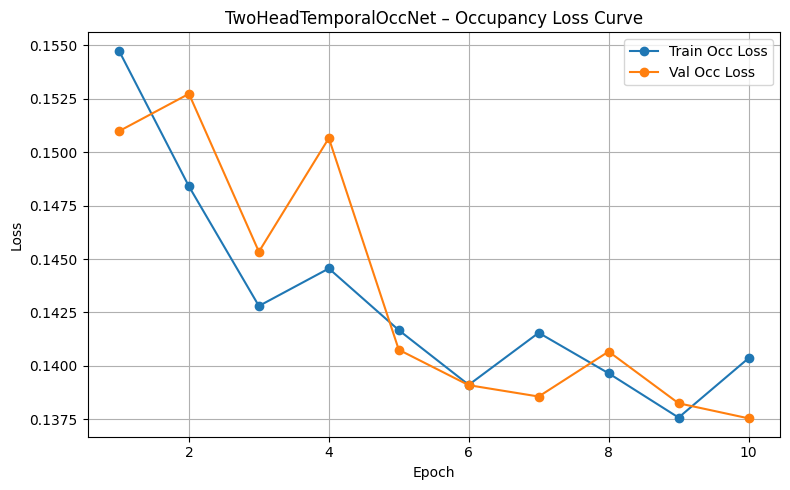

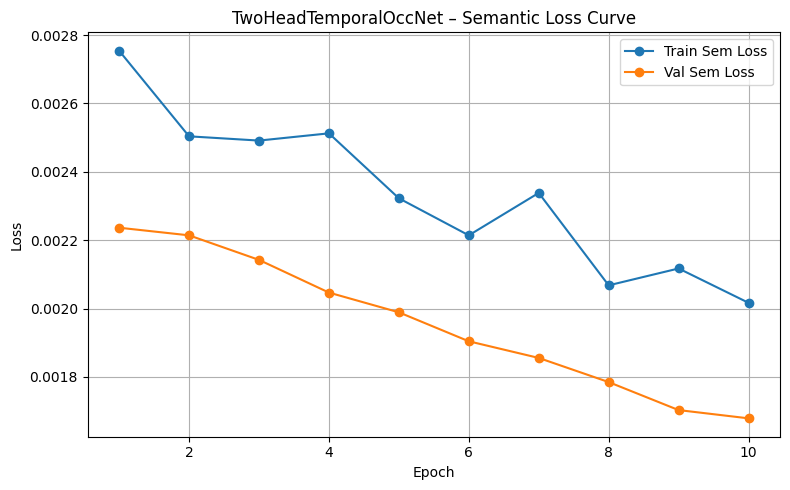

In [85]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Optional: where to save plots
os.makedirs("plots", exist_ok=True)

epochs = np.arange(1, len(train_occ_hist) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_occ_hist, marker="o", label="Train Occ Loss")
plt.plot(epochs, val_occ_hist,   marker="o", label="Val Occ Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("TwoHeadTemporalOccNet – Occupancy Loss Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("plots/twohead_occ_loss_curve.png", dpi=200)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_sem_hist, marker="o", label="Train Sem Loss")
plt.plot(epochs, val_sem_hist,   marker="o", label="Val Sem Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("TwoHeadTemporalOccNet – Semantic Loss Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("plots/twohead_sem_loss_curve.png", dpi=200)
plt.show()


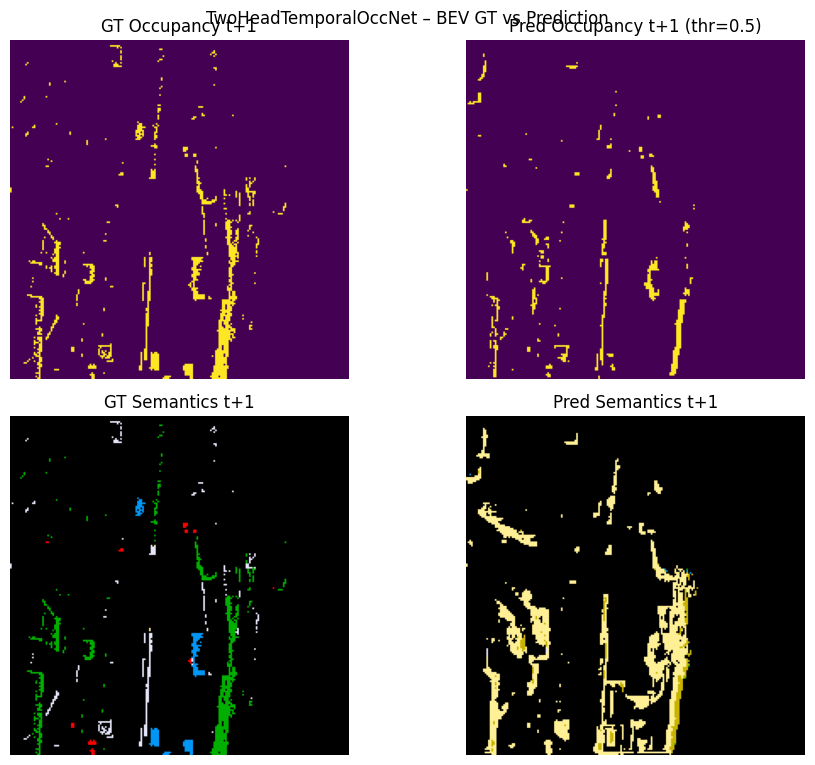

In [86]:
import torch
import numpy as np
import matplotlib.pyplot as plt

FREE_LABEL = 10  # as you defined earlier (free space class)

def colorize_semantic(sem_map):
    """
    sem_map: (H, W) int labels (0..19)
    returns: (H, W, 3) uint8 RGB
    """
    h, w = sem_map.shape
    rgb = COLOR_MAP[sem_map.reshape(-1)].reshape(h, w, 4)[..., :3]
    return rgb.astype(np.uint8)

@torch.no_grad()
def visualize_bev_sample(model, loader, device, index_in_batch=0, t_index=0, threshold=0.5):
    """
    Shows:
      Row 1: GT occupancy (binary) vs Pred occupancy (binary)
      Row 2: GT semantics (colour) vs Pred semantics (colour)
    """
    model.eval()
    batch = next(iter(loader))

    occ_obs = batch["occ_obs"].to(device)      # (B,T,1,H,W)
    occ_fut = batch["occ_fut"]                # (B,T,1,H,W)
    sem_fut = batch["sem_fut"]                # (B,T,H,W)

    occ_logits, sem_logits = model(occ_obs)   # occ: (B,T,1,H,W), sem: (B,T,C,H,W)

    B, T, _, H, W = occ_fut.shape

    b = index_in_batch
    t = min(t_index, T - 1)

    # Occupancy
    gt_occ  = occ_fut[b, t, 0].cpu().numpy()                 # (H,W)
    pred_occ_prob = torch.sigmoid(occ_logits[b, t, 0]).cpu().numpy()
    pred_occ_bin  = (pred_occ_prob > threshold).astype(np.float32)

    # Semantics
    gt_sem  = sem_fut[b, t].cpu().numpy().astype(np.int64)   # (H,W)
    pred_sem_logits = sem_logits[b, t]                       # (C,H,W)
    pred_sem = pred_sem_logits.argmax(dim=0).cpu().numpy().astype(np.int64)

    gt_sem_rgb   = colorize_semantic(gt_sem)
    pred_sem_rgb = colorize_semantic(pred_sem)

    plt.figure(figsize=(10, 8))

    # Row 1: occupancy
    plt.subplot(2, 2, 1)
    plt.imshow(gt_occ, vmin=0, vmax=1)
    plt.title(f"GT Occupancy t+{t+1}")
    plt.axis("off")

    plt.subplot(2, 2, 2)
    plt.imshow(pred_occ_bin, vmin=0, vmax=1)
    plt.title(f"Pred Occupancy t+{t+1} (thr={threshold})")
    plt.axis("off")

    # Row 2: semantics
    plt.subplot(2, 2, 3)
    plt.imshow(gt_sem_rgb)
    plt.title(f"GT Semantics t+{t+1}")
    plt.axis("off")

    plt.subplot(2, 2, 4)
    plt.imshow(pred_sem_rgb)
    plt.title(f"Pred Semantics t+{t+1}")
    plt.axis("off")

    plt.suptitle("TwoHeadTemporalOccNet – BEV GT vs Prediction", y=0.95)
    plt.tight_layout()
    plt.show()

# Example call (after training):
visualize_bev_sample(model, val_loader, device, index_in_batch=0, t_index=0)


In [90]:
import os
import numpy as np

def inspect_npz(npz_path):
    if not os.path.exists(npz_path):
        print("❌ File not found:", npz_path)
        return

    # ✅ Allow loading object arrays
    data = np.load(npz_path, allow_pickle=True)

    print("✅ Loaded:", npz_path)
    print("📌 Keys:", data.files)

    for k in data.files:
        arr = data[k]
        # Some fields may be objects, so shape/dtype might not exist
        try:
            print(f"  - {k} : shape={arr.shape}, dtype={arr.dtype}")
        except:
            print(f"  - {k} : Python object ({type(arr)})")

# ✅ Correct path
npz_path = "/content/drive/MyDrive/Uniocc/datasets/Carla-2Hz-train/scene_Town01/0.npz"
inspect_npz(npz_path)


✅ Loaded: /content/drive/MyDrive/Uniocc/datasets/Carla-2Hz-train/scene_Town01/0.npz
📌 Keys: ['occ_label', 'occ_mask_lidar', 'occ_mask_camera', 'ego_to_world_transformation', 'occ_flow_forward', 'occ_flow_backward', 'cameras', 'annotations']
  - occ_label : shape=(200, 200, 16), dtype=int64
  - occ_mask_lidar : shape=(200, 200, 16), dtype=bool
  - occ_mask_camera : shape=(200, 200, 16), dtype=bool
  - ego_to_world_transformation : shape=(4, 4), dtype=float64
  - occ_flow_forward : shape=(200, 200, 16, 3), dtype=float64
  - occ_flow_backward : shape=(200, 200, 16, 3), dtype=float64
  - cameras : shape=(4,), dtype=object
  - annotations : shape=(1,), dtype=object


In [91]:
root = "/content/drive/MyDrive/Uniocc/datasets/Carla-2Hz-train"
print(os.listdir(root))


['scene_Town01_Opt', 'scene_Town01', 'scene_Town06', 'scene_Town04_Opt', 'scene_Town03', 'scene_Town02', 'scene_Town04']


# RUN ON CARLA

In [107]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

FREE_LABEL = 10

COLOR_MAP = np.array([
    [255, 255, 255, 255],  # 0 undefined
    [0, 0, 255, 255],      # 1 car
    [255, 192, 203, 255],  # 2 bicycle
    [220, 180, 0, 255],    # 3 motorcycle
    [255, 0, 0, 255],      # 4 pedestrian
    [255, 240, 150, 255],  # 5 traffic_cone
    [0, 175, 0, 255],      # 6 vegetation
    [230, 230, 250, 255],  # 7 road
    [0, 175, 0, 255],      # 8 terrain
    [128, 128, 128, 255],  # 9 building
    [0, 0, 0, 255]         # 10 free
], dtype=np.float32)


In [108]:
class UniOccNet(nn.Module):
    def __init__(self, obs_len=4, pred_len=1):
        super().__init__()
        self.obs_len = obs_len
        self.pred_len = pred_len

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU()
        )

        self.fusion = nn.Conv2d(32 * obs_len, 64, 3, padding=1)

        # Occupancy head
        self.occ_head = nn.Conv2d(64, pred_len, 1)

        # Semantic head (11 classes including free)
        self.sem_head = nn.Conv2d(64, 11, 1)

    def forward(self, occ_obs):
        """
        occ_obs: (B, T_obs, 1, H, W)
        """
        B, T, C, H, W = occ_obs.shape
        assert T == self.obs_len, f"Expected T_obs={self.obs_len}, got {T}"

        # Encode each frame
        encs = []
        for t in range(T):
            feat = self.encoder(occ_obs[:, t])
            encs.append(feat)

        fused = torch.cat(encs, dim=1)
        fused = self.fusion(fused)

        occ_logits = self.occ_head(fused)  # (B, pred_len, H, W)
        sem_logits = self.sem_head(fused)  # (B, 11, H, W)

        return occ_logits, sem_logits


In [109]:
pos_weight = torch.tensor(25.0).to(device)
occ_loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
sem_loss_fn = nn.CrossEntropyLoss()


In [110]:
def load_npz_occ(npz_path):
    data = np.load(npz_path, allow_pickle=True)
    occ = data["occ_label"]  # (200,200,16)
    occ = (occ != FREE_LABEL).astype(np.float32)

    # Build fake 4-frame history (T=4)
    occ = np.stack([occ[..., 0]] * 4, axis=0)  # (4,200,200)

    occ = occ[:, None, :, :]   # (T,1,H,W)
    return occ


@torch.no_grad()
def run_model_on_npz(model, npz_path):
    occ = load_npz_occ(npz_path)  # (4,1,H,W)
    occ = torch.tensor(occ).unsqueeze(0).float().to(device)  # (1,4,1,H,W)

    occ_logits, sem_logits = model(occ)

    occ_prob = torch.sigmoid(occ_logits)[0, 0].cpu().numpy()
    sem_pred = torch.argmax(sem_logits, dim=1)[0].cpu().numpy()

    return occ_prob, sem_pred


In [111]:
def visualize_slice(gt, pred, slice_idx=None):
    H, W = gt.shape
    plt.figure(figsize=(14,4))

    plt.subplot(1,3,1)
    plt.imshow(gt, cmap="gray")
    plt.title("✅ Ground Truth")

    plt.subplot(1,3,2)
    plt.imshow(pred, cmap="inferno", vmin=0, vmax=1)
    plt.title("⚠️ Predicted Probabilities")

    plt.subplot(1,3,3)
    plt.imshow(pred > 0.5, cmap="gray")
    plt.title("⚡ Predicted > 0.5")

    plt.tight_layout()
    plt.show()


In [112]:
def render_semantic_3d(sem_vox, max_points=30000):
    H,W,Z = sem_vox.shape
    yy,xx,zz = np.meshgrid(
        np.arange(H), np.arange(W), np.arange(Z),
        indexing="ij"
    )

    flat = sem_vox.reshape(-1)
    mask = (flat != FREE_LABEL) & (flat != 0)

    xx,yy,zz,flat = xx[mask],yy[mask],zz[mask],flat[mask]

    if len(flat) > max_points:
        idx = np.random.choice(len(flat), max_points, replace=False)
        xx,yy,zz,flat = xx[idx],yy[idx],zz[idx],flat[idx]

    colors = COLOR_MAP[flat][:,:3] / 255.0

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(xx,yy,zz,c=colors,s=2)
    plt.title("🎨 3D Semantic Voxels")
    plt.show()


In [113]:
def save_pred_npz(npz_in, pred_occ, pred_sem, out_path):
    data = dict(np.load(npz_in, allow_pickle=True))
    data["pred_occ"] = pred_occ.astype(np.float32)
    data["pred_sem"] = pred_sem.astype(np.uint8)
    np.savez(out_path, **data)
    print("✅ Saved:", out_path)


In [119]:
if val_iou > best_iou:
    best_iou = val_iou
    torch.save(model.state_dict(), "temporal_occ_best.pth")
    print("✅ Saved new best checkpoint!")


Using device: cuda
Checkpoint dir: /content/drive/MyDrive/Uniocc/checkpoints


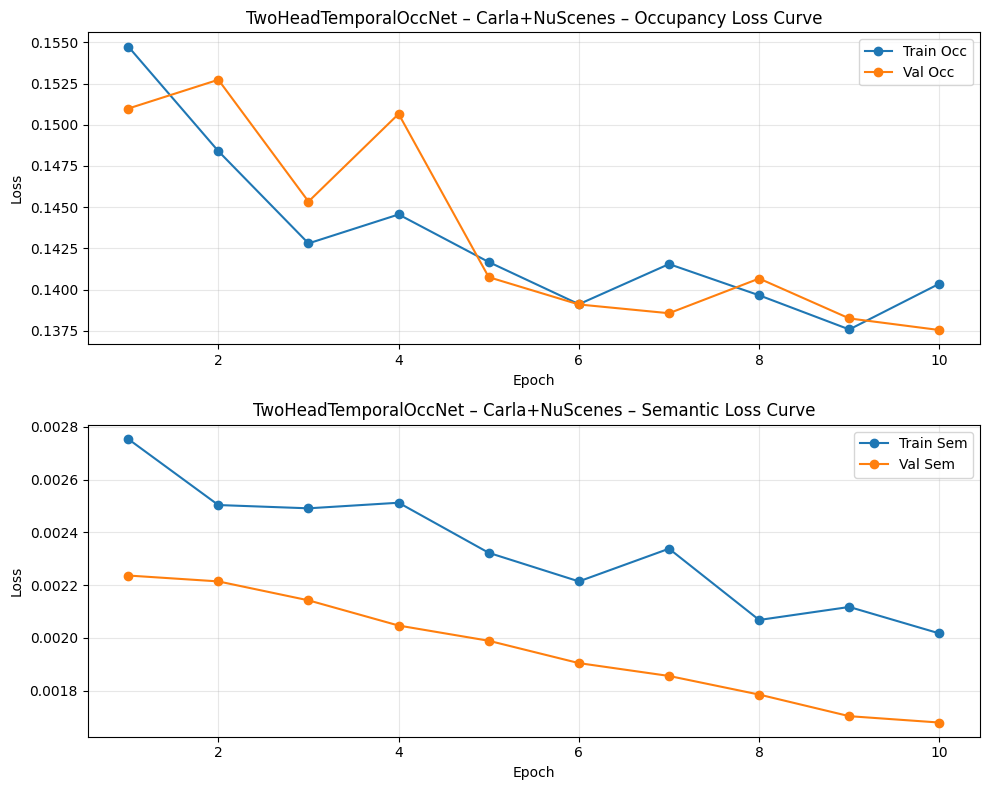

TypeError: TwoHeadTemporalOccNet.__init__() got an unexpected keyword argument 'backbone_name'

In [121]:
# ================================================================
# 0. Imports & Paths
# ================================================================
import os
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Paths (adjust if your Drive path is different) ---
CKPT_DIR   = "/content/drive/MyDrive/Uniocc/checkpoints"
NUS_ROOT   = "/content/drive/MyDrive/Uniocc/datasets/NuScenes-via-Occ3D-2Hz-mini"
CARLA_ROOT = "/content/drive/MyDrive/Uniocc/datasets/Carla-2Hz-train"

# Best semantic + temporal checkpoint
SEM_TEMPORAL_CKPT = os.path.join(CKPT_DIR, "two_head_temporal_best.pth")

print("Using device:", device)
print("Checkpoint dir:", CKPT_DIR)


# ================================================================
# 1. Plot Training Curves (Occ + Sem)
# ================================================================
def plot_training_curves(train_occ_hist, val_occ_hist,
                         train_sem_hist, val_sem_hist,
                         title_prefix="TwoHeadTemporalOccNet"):
    epochs = range(1, len(train_occ_hist) + 1)

    plt.figure(figsize=(10, 8))

    # --- Occupancy loss ---
    plt.subplot(2, 1, 1)
    plt.plot(epochs, train_occ_hist, marker="o", label="Train Occ")
    if len(val_occ_hist) == len(train_occ_hist):
        plt.plot(epochs, val_occ_hist, marker="o", label="Val Occ")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} – Occupancy Loss Curve")
    plt.grid(True, alpha=0.3)
    plt.legend()

    # --- Semantic loss ---
    plt.subplot(2, 1, 2)
    plt.plot(epochs, train_sem_hist, marker="o", label="Train Sem")
    if len(val_sem_hist) == len(train_sem_hist):
        plt.plot(epochs, val_sem_hist, marker="o", label="Val Sem")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} – Semantic Loss Curve")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call once (you already have the histories)
plot_training_curves(train_occ_hist, val_occ_hist,
                     train_sem_hist, val_sem_hist,
                     title_prefix="TwoHeadTemporalOccNet – Carla+NuScenes")


# ================================================================
# 2. Load Best Two-Head Temporal Model
# ================================================================
# Re-create the same model you used for two-head training
best_model = TwoHeadTemporalOccNet(
    backbone_name="mobilenet3d_lite",
    obs_len=4,
    fut_len=4,
    num_sem_classes=20
).to(device)

if os.path.exists(SEM_TEMPORAL_CKPT):
    state = torch.load(SEM_TEMPORAL_CKPT, map_location=device)
    best_model.load_state_dict(state)
    print(f"✅ Loaded best checkpoint: {SEM_TEMPORAL_CKPT}")
else:
    print("⚠️ Best checkpoint not found, using random weights:", SEM_TEMPORAL_CKPT)

best_model.eval()


# ================================================================
# 3. Dataset: NuScenes-mini + Carla
#    (use SAME args as in your training cells)
# ================================================================
# NOTE: adjust args to exactly match what you used before
nus_val_dataset = UniOccSemanticTemporalDataset(
    root=NUS_ROOT,
    split="val",
    obs_len=4,
    fut_len=4,
    use_semantics=True
)

# Carla-2Hz – if you don't have explicit val split, we just use 'train' to visualize
carla_val_dataset = UniOccSemanticTemporalDataset(
    root=CARLA_ROOT,
    split="train",
    obs_len=4,
    fut_len=4,
    use_semantics=True
)

print(f"NuScenes val size: {len(nus_val_dataset)}")
print(f"Carla   val size: {len(carla_val_dataset)}")


# ================================================================
# 4. Utility: Colourize semantics & draw bounding boxes
# ================================================================
# If not already defined:
# CLASS_NAMES = {0:"undefined", 1:"car", 2:"bicycle", ...}

def colorize_semantic(sem_2d):
    """
    sem_2d: (H,W) integer labels in [0,19]
    returns: (H,W,3) float image for imshow
    """
    sem_2d = np.clip(sem_2d, 0, COLOR_MAP.shape[0] - 1)
    rgb = COLOR_MAP[sem_2d][..., :3] / 255.0
    return rgb

INTEREST_CLASSES = [1, 2, 3, 4, 5]  # car, bicycle, motorcycle, pedestrian, cone etc.

def add_bboxes(ax, sem_2d, min_pixels=20):
    """
    Finds a simple bounding box per class using min/max of pixels.
    """
    H, W = sem_2d.shape
    for cls_id in INTEREST_CLASSES:
        ys, xs = np.where(sem_2d == cls_id)
        if ys.size < min_pixels:
            continue
        y_min, y_max = ys.min(), ys.max()
        x_min, x_max = xs.min(), xs.max()

        rect = Rectangle((x_min, y_min),
                         x_max - x_min + 1,
                         y_max - y_min + 1,
                         linewidth=1.0,
                         edgecolor="white",
                         facecolor="none")
        ax.add_patch(rect)
        cls_name = CLASS_NAMES.get(cls_id, str(cls_id))
        ax.text(x_min, max(y_min - 2, 0),
                cls_name,
                fontsize=6,
                color="black",
                bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))


# ================================================================
# 5. Frame-by-frame GT vs Prediction (2D) for one sequence
# ================================================================
@torch.no_grad()
def visualize_sequence_2d(model, dataset, sample_idx=0, max_future_frames=4,
                          title_prefix="NuScenes"):
    """
    Shows GT occupancy + predicted occupancy + semantic map with bounding boxes
    for a single sequence from the dataset.
    """
    model.eval()
    sample = dataset[sample_idx]

    # Shapes:
    # occ_obs: (T_obs,1,H,W), occ_fut: (T_fut,1,H,W)
    # sem_obs: (T_obs,H,W),   sem_fut: (T_fut,H,W)
    occ_obs = sample["occ_obs"].unsqueeze(0).to(device)  # (1,T_obs,1,H,W)
    occ_fut = sample["occ_fut"].cpu().numpy()           # (T_fut,1,H,W)
    sem_fut = sample["sem_fut"].cpu().numpy()           # (T_fut,H,W)

    with torch.no_grad():
        occ_logits, sem_logits = model(occ_obs)  # (1,T_fut,1,H,W), (1,T_fut,C,H,W)
        occ_prob = torch.sigmoid(occ_logits)[0].cpu().numpy()  # (T_fut,1,H,W)
        sem_pred = torch.argmax(sem_logits[0], dim=1).cpu().numpy()  # (T_fut,H,W)

    T_fut = occ_fut.shape[0]
    T_show = min(max_future_frames, T_fut)

    plt.figure(figsize=(4 * T_show, 9))

    for t in range(T_show):
        gt_occ = occ_fut[t, 0]       # (H,W)
        pred_occ = occ_prob[t, 0]    # (H,W)
        pred_sem = sem_pred[t]       # (H,W)

        # --- Row 1: Occupancy GT ---
        ax1 = plt.subplot(3, T_show, t + 1)
        ax1.imshow(gt_occ, cmap="gray")
        ax1.set_title(f"GT Occ t+{t+1}")
        ax1.axis("off")

        # --- Row 2: Predicted occupancy prob ---
        ax2 = plt.subplot(3, T_show, T_show + t + 1)
        im2 = ax2.imshow(pred_occ, cmap="viridis", vmin=0.0, vmax=1.0)
        ax2.set_title(f"Pred Occ prob t+{t+1}")
        ax2.axis("off")

        # --- Row 3: Pred semantic with boxes ---
        ax3 = plt.subplot(3, T_show, 2 * T_show + t + 1)
        rgb = colorize_semantic(pred_sem)
        ax3.imshow(rgb)
        add_bboxes(ax3, pred_sem)
        ax3.set_title(f"Pred Sem t+{t+1}")
        ax3.axis("off")

    plt.suptitle(f"{title_prefix} – Sequence #{sample_idx}", y=0.99, fontsize=14)
    plt.tight_layout()
    plt.show()


# Example: visualize from each dataset
visualize_sequence_2d(best_model, nus_val_dataset,
                      sample_idx=0, max_future_frames=4,
                      title_prefix="NuScenes-mini")

visualize_sequence_2d(best_model, carla_val_dataset,
                      sample_idx=0, max_future_frames=4,
                      title_prefix="Carla-2Hz")


# ================================================================
# 6. Simple 3D voxel visualization (GT & Pred)
#    We extrude 2D semantic maps along Z for visualization.
# ================================================================
def sem2vox(sem_2d, Z=16):
    """
    Repeat a 2D semantic map along the vertical axis to get (H,W,Z).
    """
    return np.repeat(sem_2d[..., None], Z, axis=2)  # (H,W,Z)

def scatter_semantic_3d(sem_vox, title="Semantic Voxels 3D", max_points=30000):
    """
    sem_vox: (H,W,Z) label volume
    """
    H, W, Z = sem_vox.shape
    yy, xx, zz = np.meshgrid(
        np.arange(H), np.arange(W), np.arange(Z), indexing="ij"
    )
    flat = sem_vox.reshape(-1)
    xx = xx.reshape(-1)
    yy = yy.reshape(-1)
    zz = zz.reshape(-1)

    # Drop undefined/free
    mask = (flat != 0) & (flat != FREE_LABEL)
    xx, yy, zz, flat = xx[mask], yy[mask], zz[mask], flat[mask]

    if flat.size == 0:
        print("No non-free voxels to plot.")
        return

    if flat.size > max_points:
        idx = np.random.choice(flat.size, max_points, replace=False)
        xx, yy, zz, flat = xx[idx], yy[idx], zz[idx], flat[idx]

    colors = COLOR_MAP[flat][..., :3] / 255.0

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(xx, yy, zz, c=colors, s=2)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


@torch.no_grad()
def visualize_sequence_3d_semantic(model, dataset, sample_idx=0, t_frame=0,
                                   title_prefix="NuScenes"):
    """
    Take a single future frame, convert semantic prediction to a fake 3D volume,
    and scatter-plot it.
    """
    model.eval()
    sample = dataset[sample_idx]
    occ_obs = sample["occ_obs"].unsqueeze(0).to(device)
    with torch.no_grad():
        _, sem_logits = model(occ_obs)
        sem_pred = torch.argmax(sem_logits[0], dim=1).cpu().numpy()  # (T,H,W)

    t_frame = min(t_frame, sem_pred.shape[0] - 1)
    sem_2d = sem_pred[t_frame]   # (H,W)
    sem_vox = sem2vox(sem_2d, Z=16)

    scatter_semantic_3d(sem_vox,
                        title=f"{title_prefix} – Pred Sem 3D (seq {sample_idx}, t+{t_frame+1})")


# Example 3D semantic plots
visualize_sequence_3d_semantic(best_model, nus_val_dataset,
                               sample_idx=0, t_frame=0,
                               title_prefix="NuScenes-mini")

visualize_sequence_3d_semantic(best_model, carla_val_dataset,
                               sample_idx=0, t_frame=0,
                               title_prefix="Carla-2Hz")


# ================================================================
# 7. Saving predictions back to NPZ (Carla .npz example)
# ================================================================
def save_pred_npz(npz_in_path, pred_occ_2d, pred_sem_2d, out_path):
    """
    npz_in_path: original Carla .npz file
    pred_occ_2d: (H,W) float [0,1]
    pred_sem_2d: (H,W) int [0,19]
    Saves: all original keys + 'pred_occ_2d', 'pred_sem_2d'
    """
    data = dict(np.load(npz_in_path, allow_pickle=True))
    data["pred_occ_2d"] = pred_occ_2d.astype(np.float32)
    data["pred_sem_2d"] = pred_sem_2d.astype(np.uint8)
    np.savez(out_path, **data)
    print("✅ Saved prediction NPZ:", out_path)


@torch.no_grad()
def run_model_on_carla_npz(model, npz_path, Z_proj_axis=2):
    """
    Load CARLA occ_label (H,W,Z) from .npz,
    collapse along Z to get 2D GT, run model on a dummy sequence
    using that as a single frame, and return GT + predictions.
    NOTE: this is a simple demo to connect your trained model
    with raw Carla files; for real experiments use the proper Dataset.
    """
    data = np.load(npz_path, allow_pickle=True)
    occ_label = data["occ_label"]  # (H,W,Z)
    H, W, Z = occ_label.shape

    # Binary occupancy GT (not semantic): anything not free
    gt_occ_2d = (occ_label != FREE_LABEL).any(axis=Z_proj_axis).astype(np.float32)

    # Build a dummy 1-frame "sequence" for the model: (B,T_obs,1,H,W)
    occ_obs = torch.from_numpy(gt_occ_2d[None, None, None, ...]).float().to(device)

    with torch.no_grad():
        occ_logits, sem_logits = model(occ_obs)
        occ_prob = torch.sigmoid(occ_logits)[0, 0, 0].cpu().numpy()  # (H,W)
        sem_pred = torch.argmax(sem_logits[0, 0], dim=0).cpu().numpy()  # (H,W)

    return gt_occ_2d, occ_prob, sem_pred


def visualize_carla_npz_sample(model, npz_path, out_npz_path=None):
    gt_occ, occ_prob, sem_pred = run_model_on_carla_npz(model, npz_path)

    plt.figure(figsize=(12, 4))
    # GT
    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(gt_occ, cmap="gray")
    ax1.set_title("GT Occupancy (2D proj)")
    ax1.axis("off")

    # Pred occ probability
    ax2 = plt.subplot(1, 3, 2)
    im2 = ax2.imshow(occ_prob, cmap="viridis", vmin=0, vmax=1)
    ax2.set_title("Pred Occ Probability")
    ax2.axis("off")
    plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

    # Pred semantic with boxes
    ax3 = plt.subplot(1, 3, 3)
    rgb = colorize_semantic(sem_pred)
    ax3.imshow(rgb)
    add_bboxes(ax3, sem_pred)
    ax3.set_title("Pred Semantics + Boxes")
    ax3.axis("off")

    plt.tight_layout()
    plt.show()

    if out_npz_path is not None:
        save_pred_npz(npz_path, occ_prob, sem_pred, out_npz_path)


# Example Carla .npz -> prediction -> save
example_carla_npz = os.path.join(CARLA_ROOT, "scene_Town01", "0.npz")
example_out_npz   = "/content/prediction_scene_Town01_0.npz"

visualize_carla_npz_sample(best_model, example_carla_npz,
                           out_npz_path=example_out_npz)


Using device: cuda
Checkpoint dir: /content/drive/MyDrive/Uniocc/checkpoints
✅ Loaded checkpoint: /content/drive/MyDrive/Uniocc/checkpoints/two_head_temporal_best.pth
[UniOccSemanticTemporalDataset] Found 404 samples in /content/drive/MyDrive/Uniocc/datasets/NuScenes-via-Occ3D-2Hz-mini
  obs_len=4, fut_len=4, total required frames=8
[UniOccSemanticTemporalDataset] Found 494 samples in /content/drive/MyDrive/Uniocc/datasets/Carla-2Hz-train
  obs_len=4, fut_len=4, total required frames=8
NuScenes samples: 404
Carla samples:    494


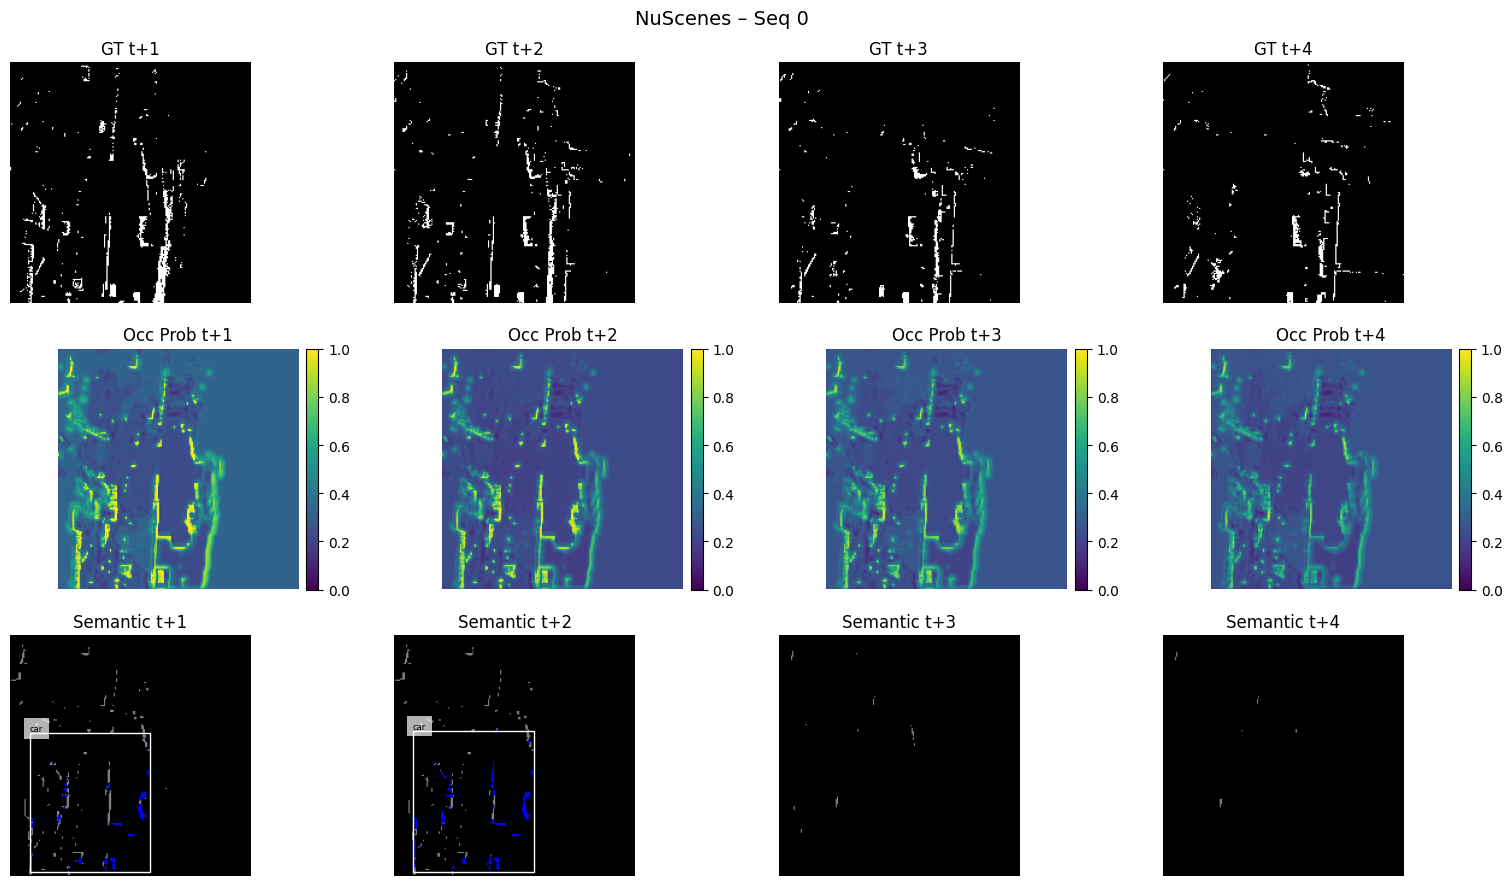

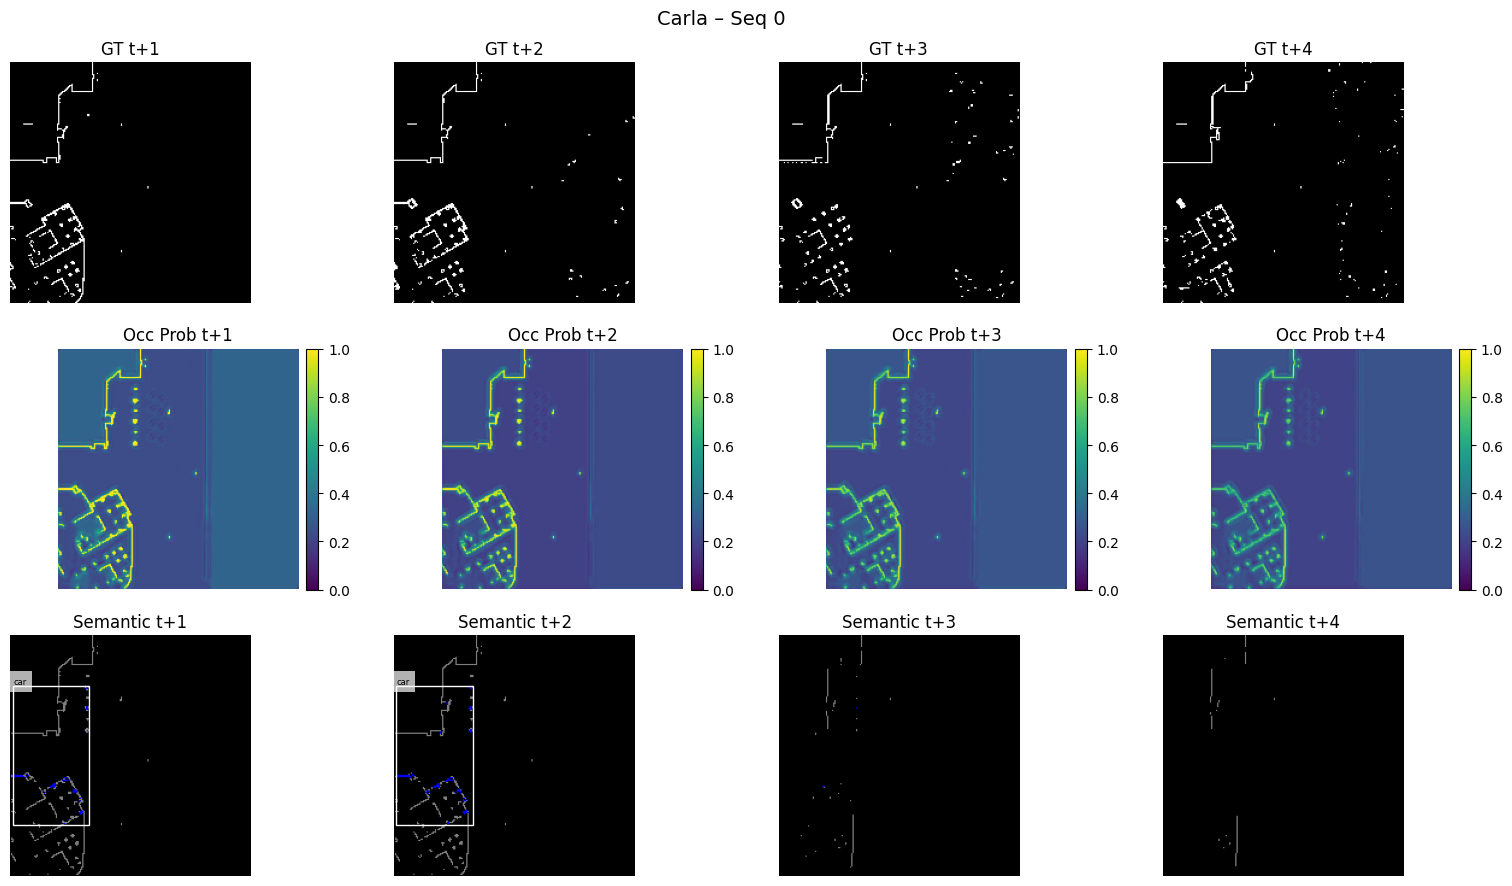

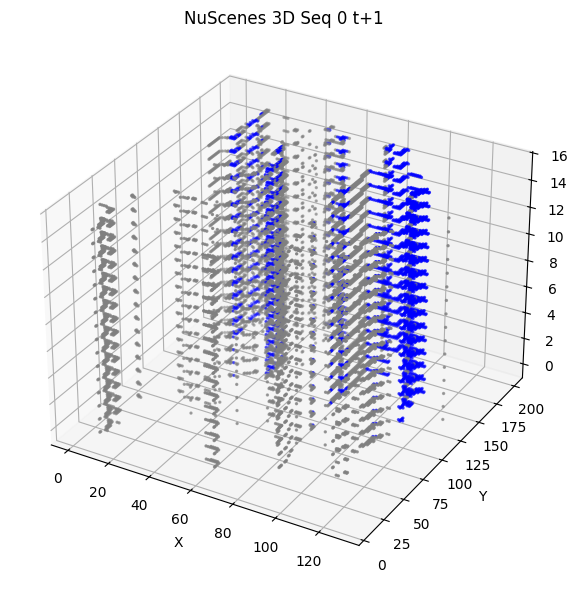

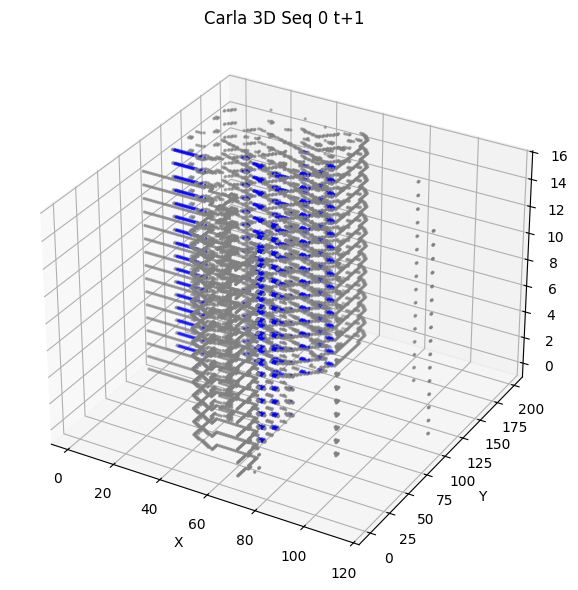

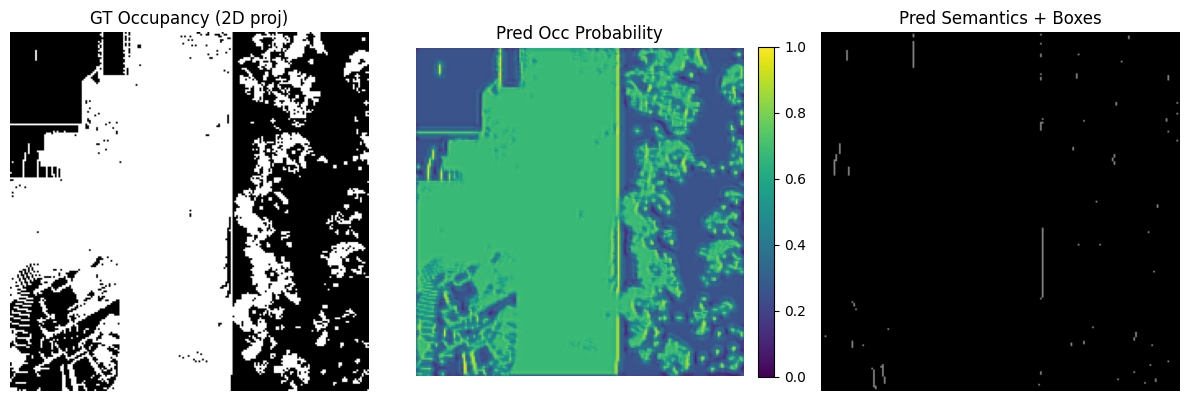

✅ Saved: /content/pred_scene_Town01_0.npz


In [125]:
# ================================================================
# 0. Imports & Paths
# ================================================================
import os
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D  # noqa

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Paths ---
CKPT_DIR   = "/content/drive/MyDrive/Uniocc/checkpoints"
NUS_ROOT   = "/content/drive/MyDrive/Uniocc/datasets/NuScenes-via-Occ3D-2Hz-mini"
CARLA_ROOT = "/content/drive/MyDrive/Uniocc/datasets/Carla-2Hz-train"

SEM_TEMPORAL_CKPT = os.path.join(CKPT_DIR, "two_head_temporal_best.pth")

print("Using device:", device)
print("Checkpoint dir:", CKPT_DIR)


# ================================================================
# 1. Load Best Two-Head Temporal Model
#    (signature: TwoHeadTemporalOccNet(obs_len, fut_len))
# ================================================================
best_model = TwoHeadTemporalOccNet(
    obs_len=4,
    fut_len=4,
).to(device)

if os.path.exists(SEM_TEMPORAL_CKPT):
    state = torch.load(SEM_TEMPORAL_CKPT, map_location=device)
    best_model.load_state_dict(state)
    print(f"✅ Loaded checkpoint: {SEM_TEMPORAL_CKPT}")
else:
    print("⚠️ Checkpoint not found — using random weights.")

best_model.eval()


# ================================================================
# 2. Load Datasets
# ================================================================
nus_val_dataset = UniOccSemanticTemporalDataset(
    root=NUS_ROOT,
    obs_len=4,
    fut_len=4
)

carla_val_dataset = UniOccSemanticTemporalDataset(
    root=CARLA_ROOT,
    obs_len=4,
    fut_len=4
)

print(f"NuScenes samples: {len(nus_val_dataset)}")
print(f"Carla samples:    {len(carla_val_dataset)}")


# ================================================================
# 3. Utilities: Colour + Boxes
#    (assumes COLOR_MAP, FREE_LABEL, CLASS_NAMES exist)
# ================================================================
def colorize_semantic(sem_2d: np.ndarray):
    """Map semantic labels -> RGB image."""
    sem_2d = np.clip(sem_2d, 0, COLOR_MAP.shape[0] - 1)
    return COLOR_MAP[sem_2d][..., :3] / 255.0

# classes we want boxes for
INTEREST_CLASSES = [1, 2, 3, 4, 5]  # car, bicycle, motorcycle, pedestrian, cone


def add_bboxes(ax, sem_2d: np.ndarray, min_pixels: int = 20):
    """Draw one bounding box per INTEREST_CLASS using min/max extents."""
    H, W = sem_2d.shape
    for cls_id in INTEREST_CLASSES:
        ys, xs = np.where(sem_2d == cls_id)
        if ys.size < min_pixels:
            continue

        x_min, x_max = xs.min(), xs.max()
        y_min, y_max = ys.min(), ys.max()

        rect = Rectangle(
            (x_min, y_min),
            x_max - x_min + 1,
            y_max - y_min + 1,
            linewidth=1.0,
            edgecolor="white",
            facecolor="none",
        )
        ax.add_patch(rect)

        name = CLASS_NAMES.get(cls_id, str(cls_id))
        ax.text(
            x_min,
            max(y_min - 2, 0),
            name,
            fontsize=6,
            color="black",
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
        )


# ================================================================
# 4. Frame-by-Frame Prediction Visualization (2D)
# ================================================================
@torch.no_grad()
def visualize_sequence_2d(model, dataset, idx: int = 0,
                          max_frames: int = 4, title: str = "Dataset"):
    """
    Shows, for a single sample:
      row1: GT occupancy
      row2: predicted occupancy prob
      row3: predicted semantics (+ simple bboxes)
    """
    model.eval()
    sample = dataset[idx]

    # occ_obs: (T_obs,1,H,W), occ_fut: (T_fut,1,H,W), sem_fut: (T_fut,H,W)
    occ_obs = sample["occ_obs"].unsqueeze(0).to(device)   # (1,T_obs,1,H,W)
    occ_fut = sample["occ_fut"].cpu().numpy()            # (T_fut,1,H,W)
    sem_fut = sample["sem_fut"].cpu().numpy()            # (T_fut,H,W)  (unused here but available)

    occ_logits, sem_logits = model(occ_obs)
    occ_prob = torch.sigmoid(occ_logits)[0].cpu().numpy()          # (T_fut,1,H,W)
    sem_pred = torch.argmax(sem_logits[0], dim=1).cpu().numpy()    # (T_fut,H,W)

    T = min(max_frames, occ_fut.shape[0])

    plt.figure(figsize=(4 * T, 9))

    for t in range(T):
        gt = occ_fut[t, 0]     # (H,W)
        po = occ_prob[t, 0]    # (H,W)
        ps = sem_pred[t]       # (H,W)

        # Row 1: GT occ
        ax1 = plt.subplot(3, T, t + 1)
        ax1.imshow(gt, cmap="gray")
        ax1.axis("off")
        ax1.set_title(f"GT t+{t+1}")

        # Row 2: predicted occ prob
        ax2 = plt.subplot(3, T, T + t + 1)
        im2 = ax2.imshow(po, cmap="viridis", vmin=0, vmax=1)
        ax2.axis("off")
        ax2.set_title(f"Occ Prob t+{t+1}")
        plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.02)

        # Row 3: predicted semantics + boxes
        ax3 = plt.subplot(3, T, 2 * T + t + 1)
        ax3.imshow(colorize_semantic(ps))
        add_bboxes(ax3, ps)
        ax3.axis("off")
        ax3.set_title(f"Semantic t+{t+1}")

    plt.suptitle(f"{title} – Seq {idx}", fontsize=14)
    plt.tight_layout()
    plt.show()


# Run on both datasets
visualize_sequence_2d(best_model, nus_val_dataset,   idx=0, title="NuScenes")
visualize_sequence_2d(best_model, carla_val_dataset, idx=0, title="Carla")


# ================================================================
# 5. Simple 3D Semantic Scatter (fake volume from 2D slice)
# ================================================================
def sem2vox(sem_2d: np.ndarray, Z: int = 16):
    """Extrude a 2D semantic map along Z → (H,W,Z)."""
    return np.repeat(sem_2d[..., None], Z, axis=2)


def scatter_semantic_3d(sem_vox: np.ndarray,
                        title: str = "3D Semantics",
                        max_points: int = 30000):
    """Scatter-plot non-empty semantic voxels."""
    H, W, Z = sem_vox.shape
    yy, xx, zz = np.meshgrid(
        np.arange(H), np.arange(W), np.arange(Z), indexing="ij"
    )

    flat = sem_vox.reshape(-1)
    xx = xx.reshape(-1)
    yy = yy.reshape(-1)
    zz = zz.reshape(-1)

    # Drop undefined / free
    mask = (flat != 0) & (flat != FREE_LABEL)
    xx, yy, zz, flat = xx[mask], yy[mask], zz[mask], flat[mask]

    if flat.size == 0:
        print("No non-free voxels to plot.")
        return

    if flat.size > max_points:
        idx = np.random.choice(flat.size, max_points, replace=False)
        xx, yy, zz, flat = xx[idx], yy[idx], zz[idx], flat[idx]

    colors = COLOR_MAP[flat][..., :3] / 255.0

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(xx, yy, zz, c=colors, s=2)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


@torch.no_grad()
def visualize_sequence_3d(model, dataset, idx: int = 0,
                          t: int = 0, title: str = "3D"):
    """Take one predicted semantic frame, extrude to voxels, and plot."""
    model.eval()
    sample = dataset[idx]
    occ_obs = sample["occ_obs"].unsqueeze(0).to(device)   # (1,T_obs,1,H,W)
    _, sem_logits = model(occ_obs)
    sem_pred = torch.argmax(sem_logits[0], dim=1).cpu().numpy()  # (T,H,W)

    t = min(t, sem_pred.shape[0] - 1)
    sem_2d = sem_pred[t]
    sem_vox = sem2vox(sem_2d, Z=16)
    scatter_semantic_3d(
        sem_vox,
        title=f"{title} Seq {idx} t+{t+1}"
    )


# Example 3D plots
visualize_sequence_3d(best_model, nus_val_dataset,
                      idx=0, t=0, title="NuScenes 3D")
visualize_sequence_3d(best_model, carla_val_dataset,
                      idx=0, t=0, title="Carla 3D")


# ================================================================
# 6. Save Predictions to NPZ for Carla
#    (project CARLA 3D -> 2D, run model, save pred back)
# ================================================================
def save_pred_npz(npz_in: str, occ_pred_2d: np.ndarray,
                  sem_pred_2d: np.ndarray, out_path: str):
    """
    npz_in: original Carla .npz file
    occ_pred_2d: (H,W) float [0,1]
    sem_pred_2d: (H,W) int [0,19]
    """
    data = dict(np.load(npz_in, allow_pickle=True))
    data["pred_occ_2d"] = occ_pred_2d.astype(np.float32)
    data["pred_sem_2d"] = sem_pred_2d.astype(np.uint8)
    np.savez(out_path, **data)
    print("✅ Saved:", out_path)


@torch.no_grad()
def run_model_on_carla_npz(model, npz_path: str,
                           z_axis: int = 2, obs_len: int = 4):
    """
    1) Load CARLA occ_label (H,W,Z)
    2) Project along Z → 2D GT occupancy
    3) Build a fake temporal sequence by repeating the 2D frame obs_len times
       to match model.obs_len
    4) Run model and return GT + predictions.
    """
    model.eval()
    data = np.load(npz_path, allow_pickle=True)
    occ = data["occ_label"]     # (H,W,Z)
    H, W, Z = occ.shape

    # 2D GT occupancy (anything not FREE_LABEL)
    gt_2d = (occ != FREE_LABEL).any(axis=z_axis).astype(np.float32)  # (H,W)

    # Build dummy sequence: (B=1, T_obs=obs_len, 1, H, W)
    # repeat same 2D frame obs_len times
    seq = np.repeat(gt_2d[None, None, ...], obs_len, axis=1)    # (1,T_obs,H,W)
    inp = torch.from_numpy(seq[:, :, None, ...]).float().to(device)  # (1,T_obs,1,H,W)

    occ_logits, sem_logits = model(inp)
    occ_pred_2d = torch.sigmoid(occ_logits)[0, -1, 0].cpu().numpy()       # last future frame
    sem_pred_2d = torch.argmax(sem_logits[0, -1], dim=0).cpu().numpy()

    return gt_2d, occ_pred_2d, sem_pred_2d


def visualize_carla_npz_sample(model, npz_path: str, out_npz_path: str = None):
    gt_2d, occ_pred_2d, sem_pred_2d = run_model_on_carla_npz(model, npz_path)

    plt.figure(figsize=(12, 4))

    # GT occupancy
    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(gt_2d, cmap="gray")
    ax1.set_title("GT Occupancy (2D proj)")
    ax1.axis("off")

    # Predicted occupancy prob
    ax2 = plt.subplot(1, 3, 2)
    im2 = ax2.imshow(occ_pred_2d, cmap="viridis", vmin=0, vmax=1)
    ax2.set_title("Pred Occ Probability")
    ax2.axis("off")
    plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

    # Predicted semantic with boxes
    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(colorize_semantic(sem_pred_2d))
    add_bboxes(ax3, sem_pred_2d)
    ax3.set_title("Pred Semantics + Boxes")
    ax3.axis("off")

    plt.tight_layout()
    plt.show()

    if out_npz_path is not None:
        save_pred_npz(npz_path, occ_pred_2d, sem_pred_2d, out_npz_path)


# Example Carla .npz -> prediction -> save
example_npz = os.path.join(CARLA_ROOT, "scene_Town01", "0.npz")
example_out = "/content/pred_scene_Town01_0.npz"

visualize_carla_npz_sample(best_model, example_npz, out_npz_path=example_out)


Using device: cuda
Checkpoint dir: /content/drive/MyDrive/Uniocc/checkpoints


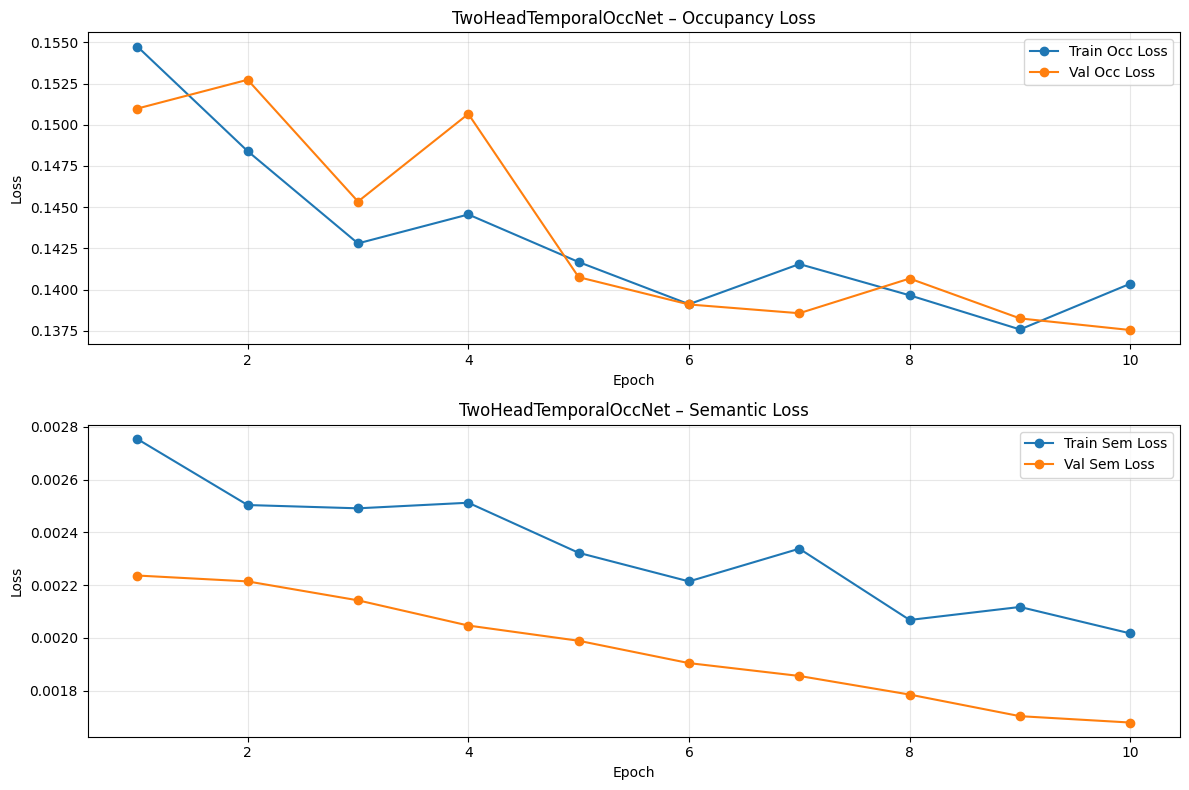

ℹ️ No IoU histories (occ_iou_hist/sem_miou_hist) found in globals(). Skipping IoU plots.
✅ Loaded checkpoint: /content/drive/MyDrive/Uniocc/checkpoints/two_head_temporal_best.pth
[UniOccSemanticTemporalDataset] Found 404 samples in /content/drive/MyDrive/Uniocc/datasets/NuScenes-via-Occ3D-2Hz-mini
  obs_len=4, fut_len=4, total required frames=8
[UniOccSemanticTemporalDataset] Found 494 samples in /content/drive/MyDrive/Uniocc/datasets/Carla-2Hz-train
  obs_len=4, fut_len=4, total required frames=8
NuScenes samples: 404
Carla samples:    494


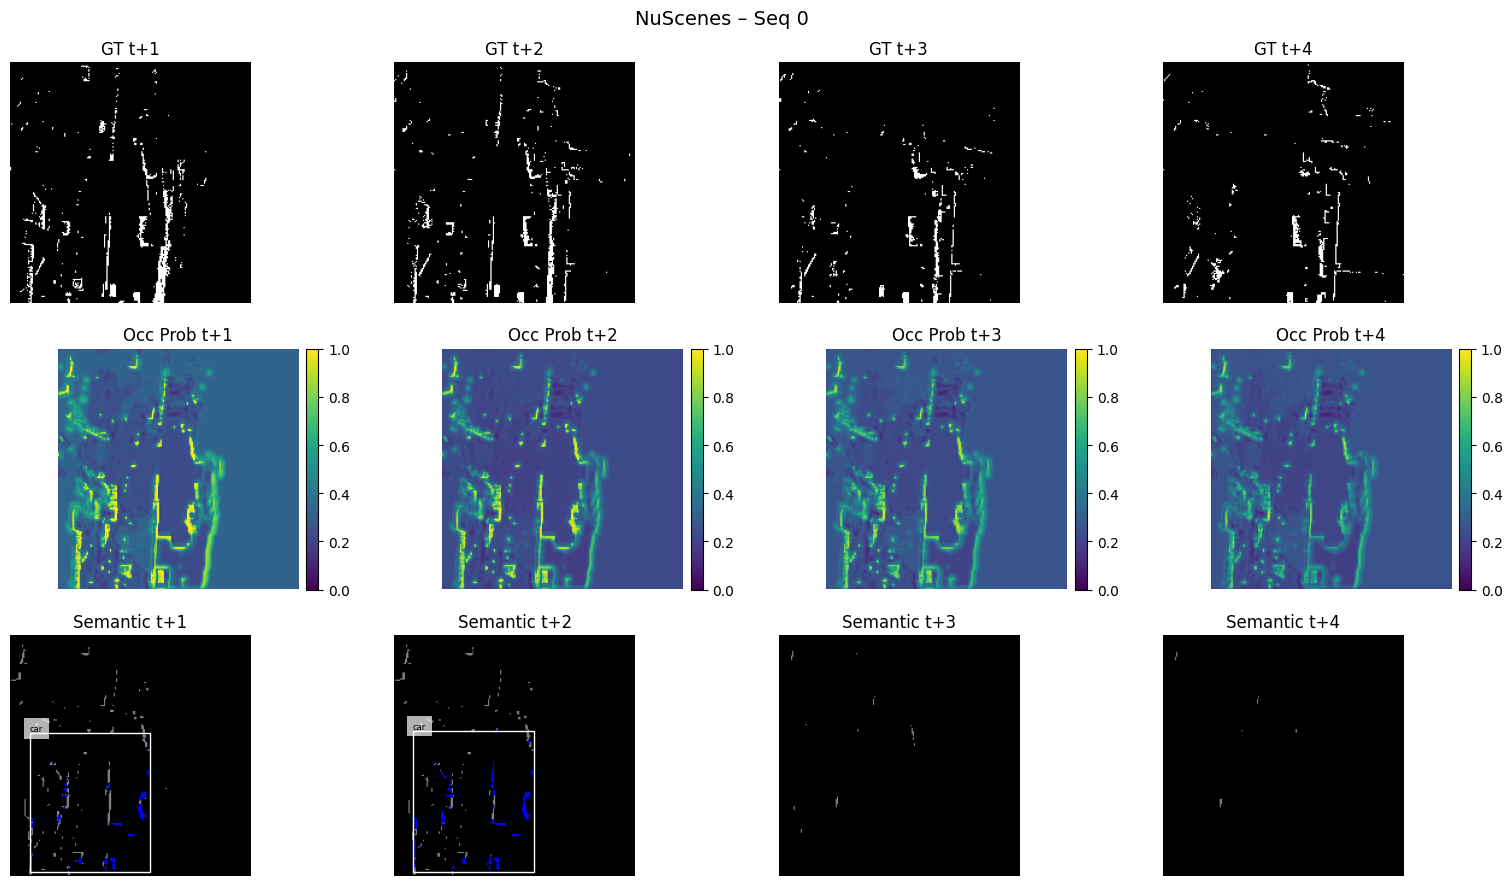

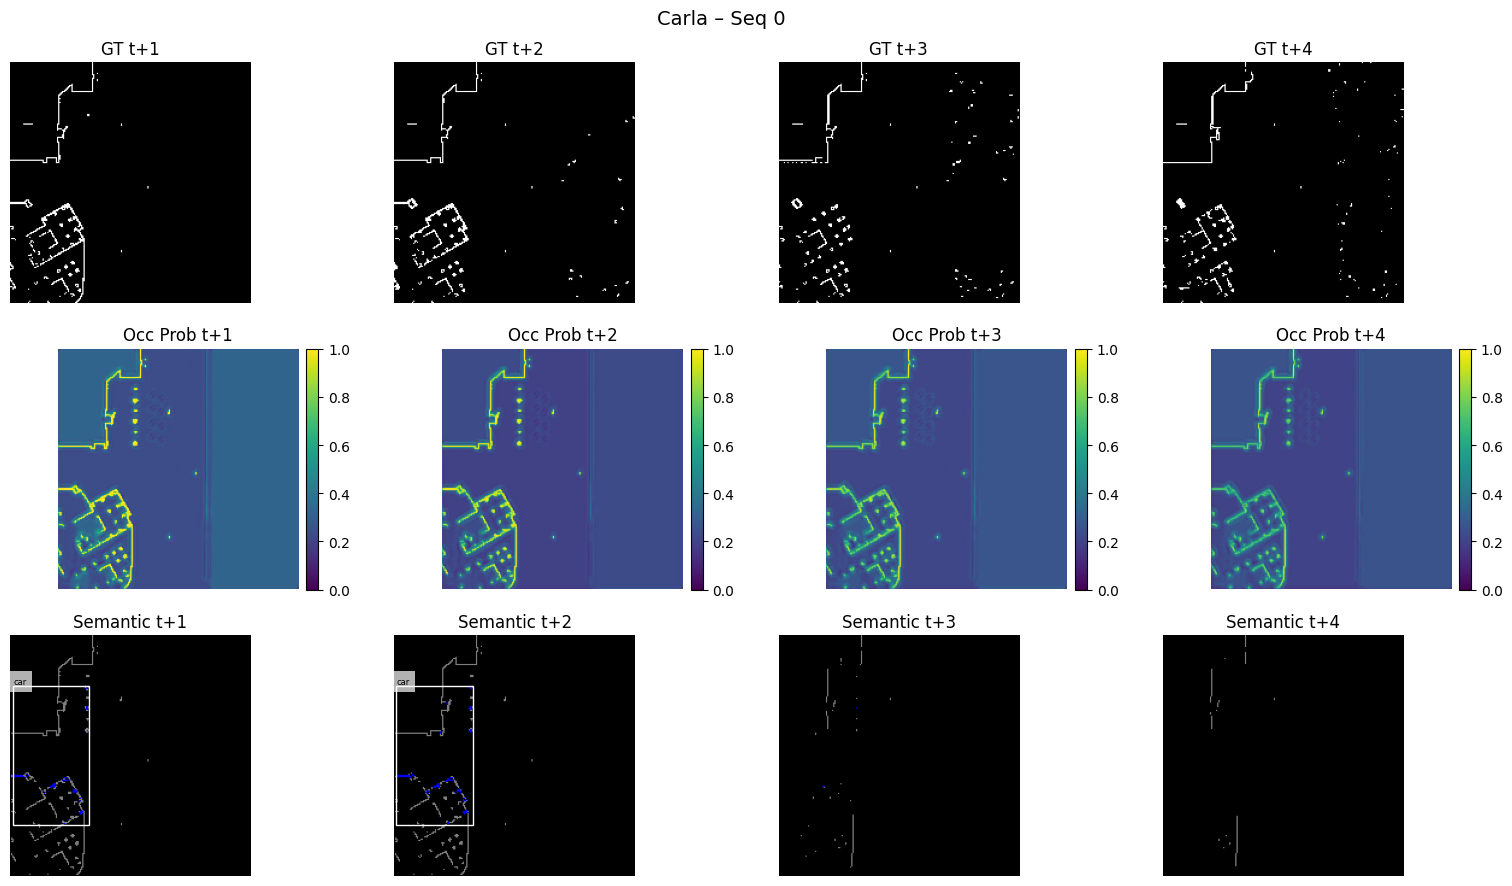

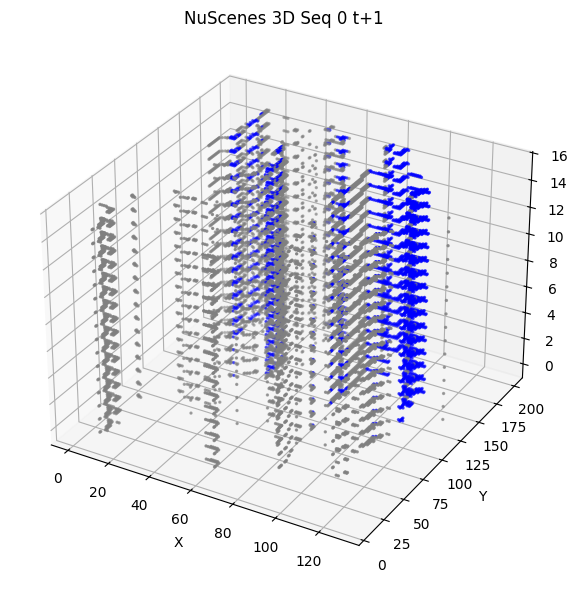

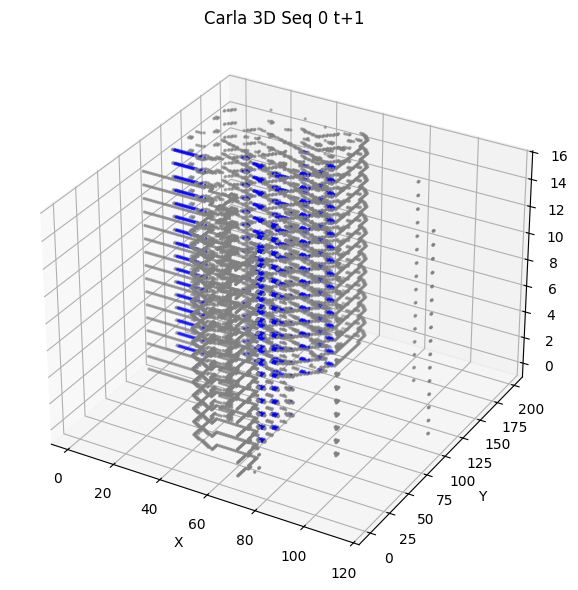

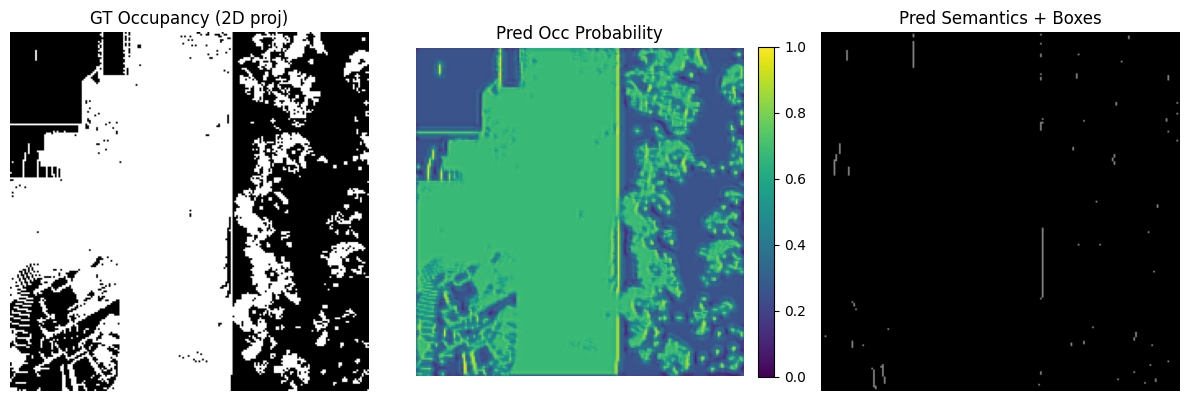

✅ Saved: /content/pred_scene_Town01_0.npz


In [126]:
# ================================================================
# 0. Imports & Paths
# ================================================================
import os
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D  # noqa

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Paths ---
CKPT_DIR   = "/content/drive/MyDrive/Uniocc/checkpoints"
NUS_ROOT   = "/content/drive/MyDrive/Uniocc/datasets/NuScenes-via-Occ3D-2Hz-mini"
CARLA_ROOT = "/content/drive/MyDrive/Uniocc/datasets/Carla-2Hz-train"

SEM_TEMPORAL_CKPT = os.path.join(CKPT_DIR, "two_head_temporal_best.pth")

print("Using device:", device)
print("Checkpoint dir:", CKPT_DIR)


# ================================================================
# 1. Plot Training Histories (Loss + IoU) IF THEY EXIST
#    (Uses globals() to avoid NameError if absent)
# ================================================================
def get_hist(name):
    return globals().get(name, None)

def plot_loss_and_iou_curves():
    train_occ_hist = get_hist("train_occ_hist")
    val_occ_hist   = get_hist("val_occ_hist")
    train_sem_hist = get_hist("train_sem_hist")
    val_sem_hist   = get_hist("val_sem_hist")

    occ_iou_hist   = get_hist("occ_iou_hist")        # optional
    sem_miou_hist  = get_hist("sem_miou_hist")       # optional
    dyn_miou_hist  = get_hist("dyn_miou_hist")       # optional
    stat_miou_hist = get_hist("stat_miou_hist")      # optional

    # ---------- Loss curves ----------
    if train_occ_hist is not None and train_sem_hist is not None:
        epochs = range(1, len(train_occ_hist) + 1)
        plt.figure(figsize=(12, 8))

        # Occupancy loss
        plt.subplot(2, 1, 1)
        plt.plot(epochs, train_occ_hist, marker='o', label="Train Occ Loss")
        if val_occ_hist is not None and len(val_occ_hist) == len(train_occ_hist):
            plt.plot(epochs, val_occ_hist, marker='o', label="Val Occ Loss")
        plt.xlabel("Epoch"); plt.ylabel("Loss")
        plt.title("TwoHeadTemporalOccNet – Occupancy Loss")
        plt.grid(True, alpha=0.3); plt.legend()

        # Semantic loss
        plt.subplot(2, 1, 2)
        plt.plot(epochs, train_sem_hist, marker='o', label="Train Sem Loss")
        if val_sem_hist is not None and len(val_sem_hist) == len(train_sem_hist):
            plt.plot(epochs, val_sem_hist, marker='o', label="Val Sem Loss")
        plt.xlabel("Epoch"); plt.ylabel("Loss")
        plt.title("TwoHeadTemporalOccNet – Semantic Loss")
        plt.grid(True, alpha=0.3); plt.legend()

        plt.tight_layout()
        plt.show()
    else:
        print("ℹ️ No loss histories (train_occ_hist/train_sem_hist) found in globals(). Skipping loss plots.")

    # ---------- IoU curves ----------
    if occ_iou_hist is not None or sem_miou_hist is not None:
        num_epochs = 0
        for h in [occ_iou_hist, sem_miou_hist, dyn_miou_hist, stat_miou_hist]:
            if h is not None:
                num_epochs = max(num_epochs, len(h))
        epochs = range(1, num_epochs + 1)

        plt.figure(figsize=(12, 8))

        # Occupancy IoU
        if occ_iou_hist is not None:
            plt.subplot(2, 1, 1)
            plt.plot(range(1, len(occ_iou_hist)+1), occ_iou_hist, marker='o', label="Occ IoU")
            plt.xlabel("Epoch"); plt.ylabel("IoU")
            plt.title("TwoHeadTemporalOccNet – Occupancy IoU")
            plt.grid(True, alpha=0.3); plt.legend()

        # Semantic IoU variants
        if sem_miou_hist is not None:
            plt.subplot(2, 1, 2)
            plt.plot(range(1, len(sem_miou_hist)+1), sem_miou_hist, marker='o', label="Sem mIoU")
            if dyn_miou_hist is not None:
                plt.plot(range(1, len(dyn_miou_hist)+1), dyn_miou_hist, marker='o', label="Dyn mIoU")
            if stat_miou_hist is not None:
                plt.plot(range(1, len(stat_miou_hist)+1), stat_miou_hist, marker='o', label="Stat mIoU")
            plt.xlabel("Epoch"); plt.ylabel("IoU")
            plt.title("TwoHeadTemporalOccNet – Semantic IoU Curves")
            plt.grid(True, alpha=0.3); plt.legend()

        plt.tight_layout()
        plt.show()
    else:
        print("ℹ️ No IoU histories (occ_iou_hist/sem_miou_hist) found in globals(). Skipping IoU plots.")


# Call once at the top
plot_loss_and_iou_curves()


# ================================================================
# 2. Load Best Two-Head Temporal Model
#    (signature: TwoHeadTemporalOccNet(obs_len, fut_len))
# ================================================================
best_model = TwoHeadTemporalOccNet(
    obs_len=4,
    fut_len=4,
).to(device)

if os.path.exists(SEM_TEMPORAL_CKPT):
    state = torch.load(SEM_TEMPORAL_CKPT, map_location=device)
    best_model.load_state_dict(state)
    print(f"✅ Loaded checkpoint: {SEM_TEMPORAL_CKPT}")
else:
    print("⚠️ Checkpoint not found — using random weights.")

best_model.eval()


# ================================================================
# 3. Load Datasets  (same temporal settings as training)
# ================================================================
nus_val_dataset = UniOccSemanticTemporalDataset(
    root=NUS_ROOT,
    obs_len=4,
    fut_len=4
)

carla_val_dataset = UniOccSemanticTemporalDataset(
    root=CARLA_ROOT,
    obs_len=4,
    fut_len=4
)

print(f"NuScenes samples: {len(nus_val_dataset)}")
print(f"Carla samples:    {len(carla_val_dataset)}")


# ================================================================
# 4. Utilities: Colour + Boxes
# ================================================================
def colorize_semantic(sem_2d: np.ndarray):
    """Map semantic labels -> RGB image."""
    sem_2d = np.clip(sem_2d, 0, COLOR_MAP.shape[0] - 1)
    return COLOR_MAP[sem_2d][..., :3] / 255.0

# classes we want boxes for
INTEREST_CLASSES = [1, 2, 3, 4, 5]  # car, bicycle, motorcycle, pedestrian, cone


def add_bboxes(ax, sem_2d: np.ndarray, min_pixels: int = 20):
    """Draw one bounding box per INTEREST_CLASS using min/max extents."""
    H, W = sem_2d.shape
    for cls_id in INTEREST_CLASSES:
        ys, xs = np.where(sem_2d == cls_id)
        if ys.size < min_pixels:
            continue

        x_min, x_max = xs.min(), xs.max()
        y_min, y_max = ys.min(), ys.max()

        rect = Rectangle(
            (x_min, y_min),
            x_max - x_min + 1,
            y_max - y_min + 1,
            linewidth=1.0,
            edgecolor="white",
            facecolor="none",
        )
        ax.add_patch(rect)

        name = CLASS_NAMES.get(cls_id, str(cls_id))
        ax.text(
            x_min,
            max(y_min - 2, 0),
            name,
            fontsize=6,
            color="black",
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
        )


# ================================================================
# 5. Frame-by-Frame Prediction Visualization (2D)
# ================================================================
@torch.no_grad()
def visualize_sequence_2d(model, dataset, idx: int = 0,
                          max_frames: int = 4, title: str = "Dataset"):
    """
    Shows, for a single sample:
      row1: GT occupancy
      row2: predicted occupancy prob
      row3: predicted semantics (+ simple bboxes)
    """
    model.eval()
    sample = dataset[idx]

    # occ_obs: (T_obs,1,H,W), occ_fut: (T_fut,1,H,W), sem_fut: (T_fut,H,W)
    occ_obs = sample["occ_obs"].unsqueeze(0).to(device)   # (1,T_obs,1,H,W)
    occ_fut = sample["occ_fut"].cpu().numpy()            # (T_fut,1,H,W)
    sem_fut = sample["sem_fut"].cpu().numpy()            # (T_fut,H,W)  (unused here but available)

    occ_logits, sem_logits = model(occ_obs)
    occ_prob = torch.sigmoid(occ_logits)[0].cpu().numpy()          # (T_fut,1,H,W)
    sem_pred = torch.argmax(sem_logits[0], dim=1).cpu().numpy()    # (T_fut,H,W)

    T = min(max_frames, occ_fut.shape[0])

    plt.figure(figsize=(4 * T, 9))

    for t in range(T):
        gt = occ_fut[t, 0]     # (H,W)
        po = occ_prob[t, 0]    # (H,W)
        ps = sem_pred[t]       # (H,W)

        # Row 1: GT occ
        ax1 = plt.subplot(3, T, t + 1)
        ax1.imshow(gt, cmap="gray")
        ax1.axis("off")
        ax1.set_title(f"GT t+{t+1}")

        # Row 2: predicted occ prob
        ax2 = plt.subplot(3, T, T + t + 1)
        im2 = ax2.imshow(po, cmap="viridis", vmin=0, vmax=1)
        ax2.axis("off")
        ax2.set_title(f"Occ Prob t+{t+1}")
        plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.02)

        # Row 3: predicted semantics + boxes
        ax3 = plt.subplot(3, T, 2 * T + t + 1)
        ax3.imshow(colorize_semantic(ps))
        add_bboxes(ax3, ps)
        ax3.axis("off")
        ax3.set_title(f"Semantic t+{t+1}")

    plt.suptitle(f"{title} – Seq {idx}", fontsize=14)
    plt.tight_layout()
    plt.show()


# Run on both datasets
visualize_sequence_2d(best_model, nus_val_dataset,   idx=0, title="NuScenes")
visualize_sequence_2d(best_model, carla_val_dataset, idx=0, title="Carla")


# ================================================================
# 6. Simple 3D Semantic Scatter (fake volume from 2D slice)
# ================================================================
def sem2vox(sem_2d: np.ndarray, Z: int = 16):
    """Extrude a 2D semantic map along Z → (H,W,Z)."""
    return np.repeat(sem_2d[..., None], Z, axis=2)


def scatter_semantic_3d(sem_vox: np.ndarray,
                        title: str = "3D Semantics",
                        max_points: int = 30000):
    """Scatter-plot non-empty semantic voxels."""
    H, W, Z = sem_vox.shape
    yy, xx, zz = np.meshgrid(
        np.arange(H), np.arange(W), np.arange(Z), indexing="ij"
    )

    flat = sem_vox.reshape(-1)
    xx = xx.reshape(-1)
    yy = yy.reshape(-1)
    zz = zz.reshape(-1)

    # Drop undefined / free
    mask = (flat != 0) & (flat != FREE_LABEL)
    xx, yy, zz, flat = xx[mask], yy[mask], zz[mask], flat[mask]

    if flat.size == 0:
        print("No non-free voxels to plot.")
        return

    if flat.size > max_points:
        idx = np.random.choice(flat.size, max_points, replace=False)
        xx, yy, zz, flat = xx[idx], yy[idx], zz[idx], flat[idx]

    colors = COLOR_MAP[flat][..., :3] / 255.0

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(xx, yy, zz, c=colors, s=2)
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


@torch.no_grad()
def visualize_sequence_3d(model, dataset, idx: int = 0,
                          t: int = 0, title: str = "3D"):
    """Take one predicted semantic frame, extrude to voxels, and plot."""
    model.eval()
    sample = dataset[idx]
    occ_obs = sample["occ_obs"].unsqueeze(0).to(device)   # (1,T_obs,1,H,W)
    _, sem_logits = model(occ_obs)
    sem_pred = torch.argmax(sem_logits[0], dim=1).cpu().numpy()  # (T,H,W)

    t = min(t, sem_pred.shape[0] - 1)
    sem_2d = sem_pred[t]
    sem_vox = sem2vox(sem_2d, Z=16)
    scatter_semantic_3d(
        sem_vox,
        title=f"{title} Seq {idx} t+{t+1}"
    )


# Example 3D plots
visualize_sequence_3d(best_model, nus_val_dataset,
                      idx=0, t=0, title="NuScenes 3D")
visualize_sequence_3d(best_model, carla_val_dataset,
                      idx=0, t=0, title="Carla 3D")


# ================================================================
# 7. Save Predictions to NPZ for Carla
#    (project CARLA 3D -> 2D, run model, save pred back)
# ================================================================
def save_pred_npz(npz_in: str, occ_pred_2d: np.ndarray,
                  sem_pred_2d: np.ndarray, out_path: str):
    """
    npz_in: original Carla .npz file
    occ_pred_2d: (H,W) float [0,1]
    sem_pred_2d: (H,W) int [0,19]
    """
    data = dict(np.load(npz_in, allow_pickle=True))
    data["pred_occ_2d"] = occ_pred_2d.astype(np.float32)
    data["pred_sem_2d"] = sem_pred_2d.astype(np.uint8)
    np.savez(out_path, **data)
    print("✅ Saved:", out_path)


@torch.no_grad()
def run_model_on_carla_npz(model, npz_path: str,
                           z_axis: int = 2, obs_len: int = 4):
    """
    1) Load CARLA occ_label (H,W,Z)
    2) Project along Z → 2D GT occupancy
    3) Build a fake temporal sequence by repeating the 2D frame obs_len times
       to match model.obs_len
    4) Run model and return GT + predictions.
    """
    model.eval()
    data = np.load(npz_path, allow_pickle=True)
    occ = data["occ_label"]     # (H,W,Z)

    # 2D GT occupancy (anything not FREE_LABEL)
    gt_2d = (occ != FREE_LABEL).any(axis=z_axis).astype(np.float32)  # (H,W)

    # Build dummy sequence: (B=1, T_obs=obs_len, 1, H, W)
    seq = np.repeat(gt_2d[None, None, ...], obs_len, axis=1)    # (1,T_obs,H,W)
    inp = torch.from_numpy(seq[:, :, None, ...]).float().to(device)  # (1,T_obs,1,H,W)

    occ_logits, sem_logits = model(inp)
    occ_pred_2d = torch.sigmoid(occ_logits)[0, -1, 0].cpu().numpy()       # last future frame
    sem_pred_2d = torch.argmax(sem_logits[0, -1], dim=0).cpu().numpy()

    return gt_2d, occ_pred_2d, sem_pred_2d


def visualize_carla_npz_sample(model, npz_path: str, out_npz_path: str = None):
    gt_2d, occ_pred_2d, sem_pred_2d = run_model_on_carla_npz(model, npz_path)

    plt.figure(figsize=(12, 4))

    # GT occupancy
    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(gt_2d, cmap="gray")
    ax1.set_title("GT Occupancy (2D proj)")
    ax1.axis("off")

    # Predicted occupancy prob
    ax2 = plt.subplot(1, 3, 2)
    im2 = ax2.imshow(occ_pred_2d, cmap="viridis", vmin=0, vmax=1)
    ax2.set_title("Pred Occ Probability")
    ax2.axis("off")
    plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

    # Predicted semantic with boxes
    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(colorize_semantic(sem_pred_2d))
    add_bboxes(ax3, sem_pred_2d)
    ax3.set_title("Pred Semantics + Boxes")
    ax3.axis("off")

    plt.tight_layout()
    plt.show()

    if out_npz_path is not None:
        save_pred_npz(npz_path, occ_pred_2d, sem_pred_2d, out_npz_path)


# Example Carla .npz -> prediction -> save
example_npz = os.path.join(CARLA_ROOT, "scene_Town01", "0.npz")
example_out = "/content/pred_scene_Town01_0.npz"

visualize_carla_npz_sample(best_model, example_npz, out_npz_path=example_out)
